# This notebook contains experiments with Amazon reviews

In [2]:
import numpy as np
import pandas as pd
from experiment_utils import *
# Adjust the path for Jupyter notebooks
import os
import sys
from joblib import dump, load
from tqdm import tqdm
home_dir = os.path.abspath("..")  # Move up to the home directory
sys.path.append(home_dir)
from comparator.TI_estimator.simulation import *
from comparator.TI_estimator.Qmod import *

src_path = os.path.abspath("../src")
sys.path.append(src_path)

from models import *
from utils import *

import matplotlib.pyplot as plt
import seaborn as sns

p = 768 #if exclude confounder
# p = 769 #if include confounder

In [2]:
def text_trial_single(n=2000, p=768, adjusted_ate=1, unadjusted_ate=2, embeddings=None, simulated_df=None,
                          cross_fit=True, n_folds=5, ps_model='torch_nn',or_model='torch_nn',w_model='kernel_ridge_regression', random_seed=42, stds_return=True, coverage_return=False):
    if p==768:
        ate = unadjusted_ate
    else:
        ate = adjusted_ate
    sampled_df = simulated_df.sample(n=n,replace=False,random_state=random_seed).reset_index()    
    
    # Qmodel
    mod = QNet(batch_size = 64, # batch size for training
           a_weight = 0.1,  # loss weight for A ~ text
           y_weight = 0.1,  # loss weight for Y ~ A + text
           mlm_weight=1.0,  # loss weight for DistlBert
           modeldir='model/train') # directory for saving the best model
    mod.train(sampled_df['text'],  # texts in training data
           sampled_df['T'],     # treatments in training data
          sampled_df['C'],     # confounds in training data, binary
          sampled_df['Y'],     # outcomes in training data
          epochs=1,   # the maximum number of training epochs
          # learning_rate = 2e-5)  # learning rate for the training
          learning_rate = 1e-3) 
    Q0, Q1, A, Y, _ = mod.get_Q(sampled_df['text'], sampled_df['T'], sampled_df['C'], sampled_df['Y'])
    g = get_propensities(A, Q0, Q1, 
                     model_type='GaussianProcessRegression', # choose the nonparametric model
                     kernel=None,    # kernel function for GPR
                     random_state=42) # random seed for GPR
    att_ti, std_att_ti, _, _ = get_TI_estimator(g, Q0, Q1, A, Y, 
                  error=0.05)[0].values
    ate_ti, std_ate_ti, _, _ = ate_aiptw(np.array(Q0),np.array(Q1),A,Y,g,error_bound=0.05)
    

    # our method
    df = pd.merge(sampled_df, embeddings, on='text', how='inner')
    df.drop(columns=['index','Unnamed: 0','text'],inplace=True)
    df.rename(columns={'C': 'X769','T':'A', 'Y':'y'},inplace=True)
    df['mu0']=Q0
    df['mu1']=Q1
    if not stds_return:
        ates = single_trial(true_ate=ate, df_full=df, p=p, ps_model=ps_model, or_model=or_model, w_model=w_model, 
            random_seed=random_seed, cross_fit=cross_fit, n_folds=n_folds,stds_return=stds_return, coverage_return=coverage_return)
        all_ate = {'true_ate':ate,
                'ti_att':ti_att,
                'ti_ate':ti_ate,
                'ate_mr':ates['ate_mr'],
                'ate_ipw':ates['ate_ipw'],
                'ate_amr':ates['ate_amr'],
                'ate_aipw':ates['ate_aipw']}
        return all_ate, _
    else:
        ates, stds = single_trial(true_ate=ate, df_full=df, p=p, ps_model=ps_model, or_model=or_model, w_model=w_model, 
            random_seed=random_seed, cross_fit=cross_fit, n_folds=n_folds,stds_return=stds_return, coverage_return=coverage_return)
    
        all_ate = {'true_ate':ate,
                    'att_ti':att_ti,
                    'ate_ti':ate_ti,
                    'ate_mr':ates['ate_mr'],
                    'ate_ipw':ates['ate_ipw'],
                    'ate_amr':ates['ate_amr'],
                    'ate_aipw':ates['ate_aipw']}
        
        all_std = {'std_att_ti': std_att_ti,
                    'std_ate_ti': std_ate_ti,
                    'std_mr': stds['ate_mr'],
                    'std_ipw': stds['ate_ipw'],
                    'std_amr': stds['ate_amr'],
                    'std_aipw': stds['ate_aipw']}
    

        return all_ate, all_std
def text_trial(num_trials=200,n=2000, p=768, adjusted_ate=1, unadjusted_ate=3, embeddings=None, simulated_df=None,
                          cross_fit=True, n_folds=5, ps_model='torch_nn',or_model='torch_nn',w_model='kernel_ridge_regression', random_seed=42, stds_return=True, coverage_return=False):
    ate_results = {
    'true_ate': [],
    'att_ti': [],
    'ate_ti': [],
    'ate_mr': [],
    'ate_ipw': [],
    'ate_amr': [],
    'ate_aipw': []
    }
    std_results = {
        'std_att_ti': [],
        'std_ate_ti': [],
        'std_mr': [],
        'std_ipw': [],
        'std_amr': [],
        'std_aipw': []
    }

    
    for i in tqdm(range(num_trials)):
        if not stds_return:
            single_all_ate = text_trial_single(n=n, p=p, adjusted_ate=adjusted_ate, unadjusted_ate=unadjusted_ate, embeddings=embeddings, simulated_df=simulated_df,
                          cross_fit=cross_fit, n_folds=n_folds, ps_model=ps_model,or_model=or_model,w_model=w_model, random_seed=random_seed+i, stds_return=stds_return, coverage_return=coverage_return)
            for key, value in single_all_ate.items():
                ate_results[key].append(value)
            return ate_results
        else:
            single_all_ate, single_all_std = text_trial_single(n=n, p=p, adjusted_ate=adjusted_ate, unadjusted_ate=unadjusted_ate, embeddings=embeddings, simulated_df=simulated_df,
                          cross_fit=cross_fit, n_folds=n_folds, ps_model=ps_model,or_model=or_model,w_model=w_model, random_seed=random_seed+i, stds_return=stds_return, coverage_return=coverage_return)
            for key, value in single_all_ate.items():
                ate_results[key].append(value)
            for key, value in single_all_std.items():
                std_results[key].append(value)

    return ate_results, std_results
    

## simulate and read files

In [3]:
raw_df = pd.read_csv('../data/music/music.csv')
simulated_df, offset =run_simulation(raw_df, propensities=[0.8, 0.6], 
                            beta_t=1.0,  # 1.0, 0.0
                            beta_c=100.0, # 50.0, 100.0
                            gamma=4.0,    # 1.0, 4.0
                            cts=True)
simulated_df = simulated_df.drop_duplicates(subset='text')
adjusted_ate = ATE_adjusted(simulated_df['C'], simulated_df['T'], simulated_df['Y'])
unadjusted_ate = ATE_unadjusted(simulated_df['T'], simulated_df['Y'])
print('adjusted ATE: ', adjusted_ate)
print('unadjusted ATE: ', unadjusted_ate)
n=1000
random_seed=42
sampled_df = simulated_df.sample(n=n,replace=False,random_state=random_seed).reset_index()  

Offset: 0.629293401965372
[0.2, 0.8]
[0.4, 0.6]
adjusted ATE:  1.0977669537942327
unadjusted ATE:  3.2468849744368296


In [2]:
embeddings = pd.read_json("../data/music/post_music.json", orient="records", lines=True)

# Main functions

In [6]:
ate_results, std_results = text_trial(num_trials=50,n=1000, p=768, adjusted_ate=adjusted_ate, unadjusted_ate=unadjusted_ate, embeddings=embeddings, simulated_df=simulated_df,
                          cross_fit=True, n_folds=5, ps_model='torch_nn',or_model='original',w_model='kernel_ridge_regression', random_seed=42, stds_return=True, coverage_return=False)
# Define the file path
ate_output_file = "results/music/ate.joblib"
std_output_file = "results/music/std.joblib"

# Ensure the directory exists
os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
os.makedirs(os.path.dirname(std_output_file), exist_ok=True)

# Save the results using joblib
dump(ate_results, ate_output_file)
print(f"Results saved to {ate_output_file}")
dump(std_results, std_output_file)
print(f"Results saved to {std_output_file}")

  0%|          | 0/50 [00:00<?, ?it/s]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


A Validation loss: 0.6609471988677978
Y Validation loss: 57.15848266601562
Validation loss: 5.7819429864883425
A accuracy: 0.655


  2%|▏         | 1/50 [01:52<1:31:40, 112.25s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]


A Validation loss: 0.675640606880188
Y Validation loss: 74.80281295776368
Validation loss: 7.5478453564643875
A accuracy: 0.595


  4%|▍         | 2/50 [03:48<1:31:28, 114.35s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


A Validation loss: 0.6793116664886475
Y Validation loss: 64.58288940429688
Validation loss: 6.5262201070785535
A accuracy: 0.585


  6%|▌         | 3/50 [05:41<1:29:12, 113.88s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


A Validation loss: 0.6707308506965637
Y Validation loss: 62.728123321533204
Validation loss: 6.339885417222977
A accuracy: 0.64


  8%|▊         | 4/50 [07:22<1:23:28, 108.89s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


A Validation loss: 0.6885995364189148
Y Validation loss: 62.76186279296875
Validation loss: 6.345046232938767
A accuracy: 0.645


 10%|█         | 5/50 [09:08<1:20:45, 107.67s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


A Validation loss: 0.7134568881988526
Y Validation loss: 53.59064765930176
Validation loss: 5.430410454750062
A accuracy: 0.635


 12%|█▏        | 6/50 [10:58<1:19:35, 108.53s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


A Validation loss: 0.6758975672721863
Y Validation loss: 60.1841537475586
Validation loss: 6.086005131483079
A accuracy: 0.595


 14%|█▍        | 7/50 [12:55<1:19:51, 111.43s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


A Validation loss: 0.6732009506225586
Y Validation loss: 64.3440885925293
Validation loss: 6.501728954315186
A accuracy: 0.62


 16%|█▌        | 8/50 [14:54<1:19:43, 113.89s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


A Validation loss: 0.6380597400665283
Y Validation loss: 55.9267179107666
Validation loss: 5.656477765083313
A accuracy: 0.67


 18%|█▊        | 9/50 [16:30<1:13:53, 108.14s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


A Validation loss: 0.7367748594284058
Y Validation loss: 65.86317527770996
Validation loss: 6.659995013713837
A accuracy: 0.435


 20%|██        | 10/50 [18:12<1:10:49, 106.24s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


A Validation loss: 0.6736442518234252
Y Validation loss: 68.63062255859376
Validation loss: 6.930426681041718
A accuracy: 0.65


 22%|██▏       | 11/50 [20:20<1:13:25, 112.95s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


A Validation loss: 0.6391371345520019
Y Validation loss: 77.36870361328126
Validation loss: 7.800784074783326
A accuracy: 0.69


 24%|██▍       | 12/50 [22:18<1:12:33, 114.56s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


A Validation loss: 0.6563126182556153
Y Validation loss: 52.959649658203126
Validation loss: 5.361596227645875
A accuracy: 0.64


 26%|██▌       | 13/50 [24:15<1:11:07, 115.34s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


A Validation loss: 0.6861941385269165
Y Validation loss: 65.15971168518067
Validation loss: 6.584590582370759
A accuracy: 0.645


 28%|██▊       | 14/50 [25:56<1:06:33, 110.92s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


A Validation loss: 0.651857430934906
Y Validation loss: 73.7110675048828
Validation loss: 7.436292493581771
A accuracy: 0.645


 30%|███       | 15/50 [27:46<1:04:30, 110.59s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


A Validation loss: 0.6860342407226563
Y Validation loss: 57.83906677246094
Validation loss: 5.85251010131836
A accuracy: 0.56


 32%|███▏      | 16/50 [29:40<1:03:18, 111.72s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


A Validation loss: 0.698720576763153
Y Validation loss: 62.185331115722654
Validation loss: 6.288405169248581
A accuracy: 0.565


 34%|███▍      | 17/50 [31:28<1:00:43, 110.41s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


A Validation loss: 0.6770102882385254
Y Validation loss: 59.50799608230591
Validation loss: 6.018500637054443
A accuracy: 0.595


 36%|███▌      | 18/50 [33:27<1:00:14, 112.97s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


A Validation loss: 0.6582907819747925
Y Validation loss: 77.00595596313477
Validation loss: 7.766424674510956
A accuracy: 0.665


 38%|███▊      | 19/50 [35:26<59:26, 115.05s/it]  Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


A Validation loss: 0.6409691572189331
Y Validation loss: 70.42851989746094
Validation loss: 7.106948905467988
A accuracy: 0.66


 40%|████      | 20/50 [37:21<57:28, 114.95s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


A Validation loss: 0.6409229016304017
Y Validation loss: 75.05245910644531
Validation loss: 7.569338200807572
A accuracy: 0.66


 42%|████▏     | 21/50 [39:02<53:30, 110.69s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


A Validation loss: 0.6734698414802551
Y Validation loss: 68.48461097717285
Validation loss: 6.915808081865311
A accuracy: 0.62


 44%|████▍     | 22/50 [41:08<53:47, 115.28s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


A Validation loss: 0.684701189994812
Y Validation loss: 63.48872894287109
Validation loss: 6.41734301328659
A accuracy: 0.64


 46%|████▌     | 23/50 [42:47<49:44, 110.55s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


A Validation loss: 0.6571051812171936
Y Validation loss: 64.26004028320312
Validation loss: 6.491714546442032
A accuracy: 0.635


 48%|████▊     | 24/50 [44:46<48:54, 112.87s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


A Validation loss: 0.6817461395263672
Y Validation loss: 76.4242626953125
Validation loss: 7.710600883483888
A accuracy: 0.64


 50%|█████     | 25/50 [46:35<46:37, 111.90s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


A Validation loss: 0.7099709177017212
Y Validation loss: 72.04640594482422
Validation loss: 7.275637686252594
A accuracy: 0.605


 52%|█████▏    | 26/50 [48:22<44:05, 110.22s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]


A Validation loss: 0.6740197324752808
Y Validation loss: 58.66034675598144
Validation loss: 5.933436648845673
A accuracy: 0.63


 54%|█████▍    | 27/50 [50:28<44:09, 115.17s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


A Validation loss: 0.6884042882919311
Y Validation loss: 60.973944396972655
Validation loss: 6.166234868526459
A accuracy: 0.58


 56%|█████▌    | 28/50 [52:37<43:43, 119.26s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


A Validation loss: 0.6848245072364807
Y Validation loss: 65.80867523193359
Validation loss: 6.649349973917007
A accuracy: 0.635


 58%|█████▊    | 29/50 [54:21<40:08, 114.70s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


A Validation loss: 0.7387118208408355
Y Validation loss: 54.88365600585937
Validation loss: 5.562236782670021
A accuracy: 0.59


 60%|██████    | 30/50 [55:52<35:51, 107.60s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]


A Validation loss: 0.6562560081481934
Y Validation loss: 82.4341748046875
Validation loss: 8.30904308128357
A accuracy: 0.635


 62%|██████▏   | 31/50 [57:26<32:44, 103.38s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


A Validation loss: 0.6576982545852661
Y Validation loss: 62.70938934326172
Validation loss: 6.336708759784699
A accuracy: 0.64


 64%|██████▍   | 32/50 [59:26<32:29, 108.32s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


A Validation loss: 0.6481479430198669
Y Validation loss: 65.92558929443359
Validation loss: 6.657373723745347
A accuracy: 0.665


 66%|██████▌   | 33/50 [1:01:33<32:18, 114.04s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


A Validation loss: 0.6636622452735901
Y Validation loss: 57.612411994934085
Validation loss: 5.827607424020767
A accuracy: 0.63


 68%|██████▊   | 34/50 [1:03:25<30:14, 113.42s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]


A Validation loss: 0.6711564946174622
Y Validation loss: 55.83482788085937
Validation loss: 5.650598437547684
A accuracy: 0.605


 70%|███████   | 35/50 [1:05:07<27:30, 110.06s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


A Validation loss: 0.6594131827354431
Y Validation loss: 59.72413833618164
Validation loss: 6.038355151891708
A accuracy: 0.635


 72%|███████▏  | 36/50 [1:06:49<25:07, 107.65s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


A Validation loss: 0.6631300187110901
Y Validation loss: 52.81834259033203
Validation loss: 5.348147260904312
A accuracy: 0.635


 74%|███████▍  | 37/50 [1:08:40<23:32, 108.63s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


A Validation loss: 0.6704920506477356
Y Validation loss: 71.74411529541015
Validation loss: 7.2414607346057895
A accuracy: 0.61


 76%|███████▌  | 38/50 [1:10:37<22:14, 111.21s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


A Validation loss: 0.6672302341461182
Y Validation loss: 69.6273878479004
Validation loss: 7.029461808204652
A accuracy: 0.64


 78%|███████▊  | 39/50 [1:12:27<20:18, 110.74s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]


A Validation loss: 0.6941319620609283
Y Validation loss: 59.41033203125
Validation loss: 6.0104463993310935
A accuracy: 0.615


 80%|████████  | 40/50 [1:14:21<18:36, 111.67s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


A Validation loss: 0.7020635747909546
Y Validation loss: 72.97892852783202
Validation loss: 7.368099210262299
A accuracy: 0.595


 82%|████████▏ | 41/50 [1:16:16<16:54, 112.70s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


A Validation loss: 0.6694392871856689
Y Validation loss: 70.74080017089844
Validation loss: 7.141023945808412
A accuracy: 0.62


 84%|████████▍ | 42/50 [1:18:16<15:19, 114.94s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


A Validation loss: 0.6857701253890991
Y Validation loss: 72.02934020996094
Validation loss: 7.2715110335350035
A accuracy: 0.63


 86%|████████▌ | 43/50 [1:20:08<13:17, 113.96s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


A Validation loss: 0.6722608089447022
Y Validation loss: 59.272230834960936
Validation loss: 5.994449164390565
A accuracy: 0.61


 88%|████████▊ | 44/50 [1:22:02<11:24, 114.10s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]


A Validation loss: 0.6750908041000366
Y Validation loss: 51.93220260620117
Validation loss: 5.260729341030121
A accuracy: 0.6


 90%|█████████ | 45/50 [1:24:10<09:50, 118.08s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


A Validation loss: 0.6747471690177917
Y Validation loss: 78.56488128662109
Validation loss: 7.923962845563889
A accuracy: 0.635


 92%|█████████▏| 46/50 [1:25:59<07:42, 115.55s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


A Validation loss: 0.6975649094581604
Y Validation loss: 72.74492263793945
Validation loss: 7.344248754739762
A accuracy: 0.585


 94%|█████████▍| 47/50 [1:27:51<05:43, 114.33s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]


A Validation loss: 0.6844848132133484
Y Validation loss: 59.15760986328125
Validation loss: 5.98420946764946
A accuracy: 0.59


 96%|█████████▌| 48/50 [1:29:25<03:36, 108.32s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


A Validation loss: 0.6682278800010681
Y Validation loss: 84.5882290649414
Validation loss: 8.525645694494246
A accuracy: 0.62


 98%|█████████▊| 49/50 [1:30:58<01:43, 103.56s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


A Validation loss: 0.6732502579689026
Y Validation loss: 74.23909576416015
Validation loss: 7.491234602212906
A accuracy: 0.6


100%|██████████| 50/50 [1:33:01<00:00, 111.64s/it]


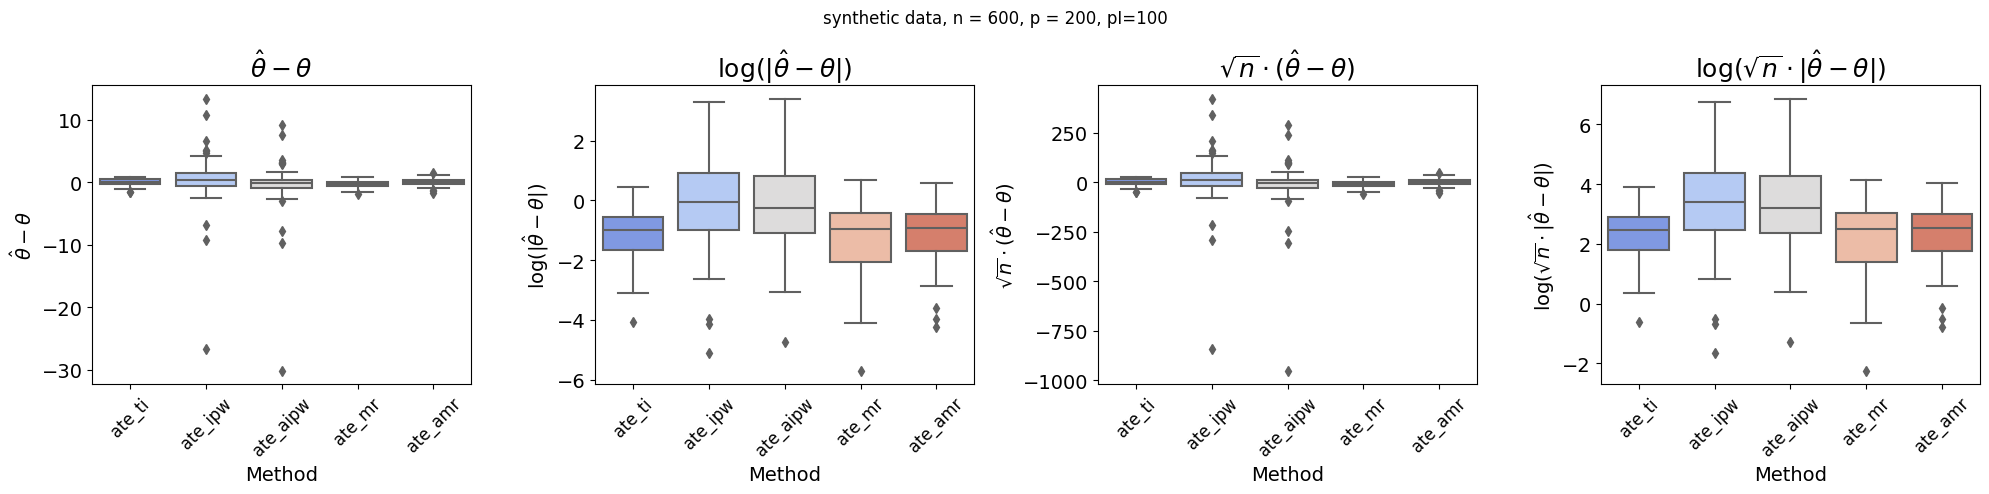

     Method  Mean_Diff  Std_Diff  Mean_Abs_Diff  Std_Abs_Diff      RMSE  \
0    ate_ti   0.028342  0.561425       0.443753      0.345086  0.562140   
1   ate_ipw   0.315420  5.168845       2.641133      4.454309  5.178460   
2  ate_aipw  -0.635173  5.079539       2.292575      4.577036  5.119097   
3    ate_mr  -0.349468  0.544298       0.480331      0.433210  0.646830   
4   ate_amr   0.062358  0.628028       0.479209      0.410691  0.631116   

    Std_RMSE  
0   1.122850  
1  10.337690  
2  10.159078  
3   1.088597  
4   1.256057  


In [8]:
# Extract keys and true ATE
methods = [ 'ate_ti', 'ate_ipw', 'ate_aipw', 'ate_mr','ate_amr']

true_ate = np.array(ate_results['true_ate'])

# Calculate metrics
n = 1000
results = {}
for method in methods:
    estimates = np.array(ate_results[method])
    results[method] = {
        'estimation_bias': estimates - true_ate,
        'abs_bias': np.abs(estimates - true_ate),
        'sqrt_n_bias': np.sqrt(n) * (estimates - true_ate),
        'sqrt_n_abs_bias': np.sqrt(n) * np.abs(estimates - true_ate)
    }

# Prepare DataFrame for plotting
plot_data = []
for method, metrics in results.items():
    for metric_name, values in metrics.items():
        if "abs" in metric_name:  # Apply log only to absolute metrics
            values = values[values > 0]  # Avoid log(0) issues
        plot_data.append(pd.DataFrame({
            'Method': [method] * len(values),
            'Metric': [metric_name] * len(values),
            'Value': np.log(values) if "abs" in metric_name else values
        }))

plot_df = pd.concat(plot_data)

# Adjust method order
plot_df['Method'] = pd.Categorical(plot_df['Method'], categories=methods, ordered=True)

# Define custom titles for each metric
metric_titles = {
    'estimation_bias': r'$\hat{\theta}-\theta$',
    'abs_bias': r'$\log(|\hat{\theta}-\theta|)$',
    'sqrt_n_bias': r'$\sqrt{n} \cdot (\hat{\theta}-\theta)$',
    'sqrt_n_abs_bias': r'$\log(\sqrt{n} \cdot|\hat{\theta}-\theta|)$'
}

# Plot all metrics in a single row with four columns
unique_metrics = plot_df['Metric'].unique()
fig, axes = plt.subplots(1, len(unique_metrics), figsize=(20, 5), sharey=False)

for i, metric in enumerate(unique_metrics):
    metric_df = plot_df[plot_df['Metric'] == metric]
    ax = sns.boxplot(
        data=metric_df,
        x='Method',
        y='Value',
        palette='coolwarm',
        ax=axes[i]
    )
    # Annotate with means
    for j, box in enumerate(ax.artists):
        method = metric_df['Method'].unique()[j]
        metric_values = metric_df[metric_df['Method'] == method]['Value']
        mean_val = metric_values.mean()
        x_pos = box.get_x() + (box.get_width() / 2)
        ax.scatter(x_pos, mean_val, color='white', s=50, edgecolor='black')
    # Set titles and labels
    ax.set_title(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=18)
    ax.set_ylabel(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=14)
    ax.set_xlabel('Method', fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    ax.tick_params(axis='x', labelsize=12, rotation=45)
plt.suptitle('synthetic data, n = 600, p = 200, pI=100')
plt.tight_layout()
plt.show()

# Compute summary statistics
summary_stats = []


for method in methods:
    estimates = np.array(ate_results[method])
    diffs = estimates - true_ate
    abs_diffs = np.abs(diffs)
    mean_diff = np.mean(diffs)
    std_diff = np.std(diffs)
    mean_abs_diff = np.mean(abs_diffs)
    std_abs_diff = np.std(abs_diffs)
    rmse = np.sqrt(np.mean(diffs**2))
    std_rmse = np.std(diffs*2)  # Standard deviation for RMSE approximation

    summary_stats.append({
        'Method': method,
        'Mean_Diff': mean_diff,
        'Std_Diff': std_diff,
        'Mean_Abs_Diff': mean_abs_diff,
        'Std_Abs_Diff': std_abs_diff,
        'RMSE': rmse,
        'Std_RMSE': std_rmse
    })

summary_df = pd.DataFrame(summary_stats)
print(summary_df)


## Make propensity score more extreme

In [27]:
raw_df = pd.read_csv('../data/music/music.csv')
simulated_df, offset =run_simulation(raw_df, propensities=[0.9, 0.7], 
                            beta_t=1.0,  # 1.0, 0.0
                            beta_c=100.0, # 50.0, 100.0
                            gamma=4.0,    # 1.0, 4.0
                            cts=True)    
simulated_df = simulated_df.drop_duplicates(subset='text')
adjusted_ate = ATE_adjusted(simulated_df['C'], simulated_df['T'], simulated_df['Y'])
unadjusted_ate = ATE_unadjusted(simulated_df['T'], simulated_df['Y'])
print('adjusted ATE: ', adjusted_ate)
print('unadjusted ATE: ', unadjusted_ate)


Offset: 0.7409417920209287
[0.1, 0.9]
[0.3, 0.7]
adjusted ATE:  0.9970386263790796
unadjusted ATE:  4.3619368425620095


In [29]:
ate_results, std_results = text_trial(num_trials=50,n=1000, p=768, adjusted_ate=adjusted_ate, unadjusted_ate=unadjusted_ate, embeddings=embeddings, simulated_df=simulated_df,
                          cross_fit=True, n_folds=5, ps_model='torch_nn',or_model='original',w_model='kernel_ridge_regression', random_seed=42, stds_return=True, coverage_return=False)
# Define the file path
ate_output_file = "results/music/ate_extreme.joblib"
std_output_file = "results/music/std_extreme.joblib"

# Ensure the directory exists
os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
os.makedirs(os.path.dirname(std_output_file), exist_ok=True)

# Save the results using joblib
dump(ate_results, ate_output_file)
print(f"Results saved to {ate_output_file}")
dump(std_results, std_output_file)
print(f"Results saved to {std_output_file}")

  0%|          | 0/50 [00:00<?, ?it/s]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


A Validation loss: 0.5681809067726136
Y Validation loss: 75.26073486328124
Validation loss: 7.582891577005386
A accuracy: 0.745


  2%|▏         | 1/50 [01:48<1:28:52, 108.83s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]


A Validation loss: 0.5833044505119324
Y Validation loss: 78.68821960449219
Validation loss: 7.927152405500412
A accuracy: 0.735


  4%|▍         | 2/50 [03:40<1:28:16, 110.35s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


A Validation loss: 0.5470200562477112
Y Validation loss: 93.56368041992188
Validation loss: 9.41107004761696
A accuracy: 0.775


  6%|▌         | 3/50 [05:42<1:30:35, 115.65s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]


A Validation loss: 0.5890583515167236
Y Validation loss: 78.31968887329101
Validation loss: 7.890874722480774
A accuracy: 0.735


  8%|▊         | 4/50 [07:39<1:29:17, 116.48s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]


A Validation loss: 0.5869109416007996
Y Validation loss: 75.53865966796874
Validation loss: 7.612557060956955
A accuracy: 0.73


 10%|█         | 5/50 [09:38<1:27:49, 117.11s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


A Validation loss: 0.6000435316562652
Y Validation loss: 80.90967864990235
Validation loss: 8.15097221815586
A accuracy: 0.715


 12%|█▏        | 6/50 [11:37<1:26:31, 117.99s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]


A Validation loss: 0.5791599345207215
Y Validation loss: 74.47321105957032
Validation loss: 7.505237099409104
A accuracy: 0.735


 14%|█▍        | 7/50 [13:29<1:23:00, 115.82s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


A Validation loss: 0.5893475413322449
Y Validation loss: 62.70788131713867
Validation loss: 6.329722885847092
A accuracy: 0.775


 16%|█▌        | 8/50 [15:12<1:18:18, 111.87s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]


A Validation loss: 0.5811469674110412
Y Validation loss: 68.95774810791016
Validation loss: 6.9538895075321205
A accuracy: 0.73


 18%|█▊        | 9/50 [17:04<1:16:27, 111.89s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


A Validation loss: 0.6077338194847107
Y Validation loss: 65.93681213378906
Validation loss: 6.654454595327378
A accuracy: 0.72


 20%|██        | 10/50 [18:56<1:14:34, 111.87s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


A Validation loss: 0.5889096236228943
Y Validation loss: 83.70431396484375
Validation loss: 8.429322358846665
A accuracy: 0.735


 22%|██▏       | 11/50 [20:35<1:10:12, 108.02s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


A Validation loss: 0.6073663330078125
Y Validation loss: 75.42828155517579
Validation loss: 7.60356478881836
A accuracy: 0.73


 24%|██▍       | 12/50 [22:27<1:09:07, 109.13s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


A Validation loss: 0.5326968574523926
Y Validation loss: 66.86759979248046
Validation loss: 6.740029664993286
A accuracy: 0.78


 26%|██▌       | 13/50 [24:17<1:07:28, 109.42s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


A Validation loss: 0.5895639157295227
Y Validation loss: 86.83810668945313
Validation loss: 8.742767060518265
A accuracy: 0.725


 28%|██▊       | 14/50 [26:11<1:06:31, 110.86s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


A Validation loss: 0.6266200470924378
Y Validation loss: 66.4323348236084
Validation loss: 6.705895487070085
A accuracy: 0.685


 30%|███       | 15/50 [28:12<1:06:21, 113.75s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


A Validation loss: 0.5256949901580811
Y Validation loss: 70.7052604675293
Validation loss: 7.123095545768739
A accuracy: 0.785


 32%|███▏      | 16/50 [29:54<1:02:34, 110.42s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


A Validation loss: 0.6010707521438599
Y Validation loss: 74.40637145996094
Validation loss: 7.50074422121048
A accuracy: 0.725


 34%|███▍      | 17/50 [31:46<1:00:59, 110.90s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


A Validation loss: 0.5791266489028931
Y Validation loss: 82.84119384765626
Validation loss: 8.342032049655915
A accuracy: 0.74


 36%|███▌      | 18/50 [33:46<1:00:38, 113.70s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


A Validation loss: 0.5342322206497192
Y Validation loss: 96.04590148925782
Validation loss: 9.658013370990753
A accuracy: 0.775


 38%|███▊      | 19/50 [35:43<59:12, 114.59s/it]  Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


A Validation loss: 0.5601766669750213
Y Validation loss: 85.04920837402344
Validation loss: 8.560938504099845
A accuracy: 0.76


 40%|████      | 20/50 [37:46<58:35, 117.19s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]


A Validation loss: 0.5367130327224732
Y Validation loss: 69.26969207763672
Validation loss: 6.9806405110359195
A accuracy: 0.78


 42%|████▏     | 21/50 [39:36<55:31, 114.90s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


A Validation loss: 0.5584478664398194
Y Validation loss: 77.6815414428711
Validation loss: 7.823998930931091
A accuracy: 0.755


 44%|████▍     | 22/50 [41:27<53:05, 113.76s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


A Validation loss: 0.5896103739738464
Y Validation loss: 77.51360412597656
Validation loss: 7.81032144999504
A accuracy: 0.725


 46%|████▌     | 23/50 [43:06<49:15, 109.45s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


A Validation loss: 0.5842674016952515
Y Validation loss: 83.97099029541016
Validation loss: 8.45552576971054
A accuracy: 0.735


 48%|████▊     | 24/50 [45:04<48:26, 111.78s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


A Validation loss: 0.5611096334457397
Y Validation loss: 67.72605773925781
Validation loss: 6.828716737270356
A accuracy: 0.755


 50%|█████     | 25/50 [46:55<46:28, 111.55s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


A Validation loss: 1.0709006214141845
Y Validation loss: 102.94709411621093
Validation loss: 10.401799473762512
A accuracy: 0.22


 52%|█████▏    | 26/50 [48:39<43:48, 109.51s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


A Validation loss: 0.5419998979568481
Y Validation loss: 81.05269500732422
Validation loss: 8.159469490528107
A accuracy: 0.77


 54%|█████▍    | 27/50 [50:29<41:57, 109.47s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]


A Validation loss: 0.6008171963691712
Y Validation loss: 65.82719787597657
Validation loss: 6.642801507234575
A accuracy: 0.725


 56%|█████▌    | 28/50 [52:21<40:28, 110.39s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]


A Validation loss: 0.5391906213760376
Y Validation loss: 71.72770202636718
Validation loss: 7.226689264774323
A accuracy: 0.77


 58%|█████▊    | 29/50 [54:12<38:40, 110.48s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]


A Validation loss: 0.5234486746788025
Y Validation loss: 68.28741333007812
Validation loss: 6.881086200475693
A accuracy: 0.795


 60%|██████    | 30/50 [56:17<38:15, 114.76s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


A Validation loss: 0.6079926061630249
Y Validation loss: 87.21057067871094
Validation loss: 8.781856328487397
A accuracy: 0.73


 62%|██████▏   | 31/50 [58:04<35:39, 112.59s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


A Validation loss: 0.5742186737060547
Y Validation loss: 92.39430892944335
Validation loss: 9.296852760314941
A accuracy: 0.755


 64%|██████▍   | 32/50 [59:55<33:37, 112.09s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


A Validation loss: 0.5636494565010071
Y Validation loss: 83.8040234375
Validation loss: 8.436767289400102
A accuracy: 0.77


 66%|██████▌   | 33/50 [1:01:40<31:08, 109.90s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


A Validation loss: 0.5842491579055786
Y Validation loss: 85.42306091308593
Validation loss: 8.600731007099153
A accuracy: 0.73


 68%|██████▊   | 34/50 [1:03:18<28:18, 106.18s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


A Validation loss: 0.5576117801666259
Y Validation loss: 68.53132232666016
Validation loss: 6.908893410682679
A accuracy: 0.8


 70%|███████   | 35/50 [1:04:53<25:44, 102.95s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


A Validation loss: 0.5820398950576782
Y Validation loss: 69.50037536621093
Validation loss: 7.008241526126861
A accuracy: 0.735


 72%|███████▏  | 36/50 [1:06:52<25:08, 107.72s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


A Validation loss: 0.6191203117370605
Y Validation loss: 74.16670989990234
Validation loss: 7.47858302116394
A accuracy: 0.705


 74%|███████▍  | 37/50 [1:08:50<24:02, 110.98s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


A Validation loss: 0.5737577390670776
Y Validation loss: 84.10749481201172
Validation loss: 8.46812525510788
A accuracy: 0.74


 76%|███████▌  | 38/50 [1:10:39<22:04, 110.41s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]


A Validation loss: 0.6621536469459534
Y Validation loss: 78.80146636962891
Validation loss: 7.946362001657486
A accuracy: 0.67


 78%|███████▊  | 39/50 [1:12:30<20:13, 110.35s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


A Validation loss: 0.5575252366065979
Y Validation loss: 77.52947113037109
Validation loss: 7.808699636697769
A accuracy: 0.755


 80%|████████  | 40/50 [1:14:05<17:38, 105.85s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]


A Validation loss: 0.5819796562194824
Y Validation loss: 67.08660614013672
Validation loss: 6.766858579635621
A accuracy: 0.745


 82%|████████▏ | 41/50 [1:15:50<15:50, 105.66s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


A Validation loss: 0.6407130622863769
Y Validation loss: 75.301181640625
Validation loss: 7.594189470291138
A accuracy: 0.675


 84%|████████▍ | 42/50 [1:17:24<13:36, 102.02s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]


A Validation loss: 0.6109743571281433
Y Validation loss: 79.08029693603515
Validation loss: 7.96912712931633
A accuracy: 0.7


 86%|████████▌ | 43/50 [1:19:09<12:00, 102.87s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


A Validation loss: 0.5716025757789612
Y Validation loss: 84.72888488769532
Validation loss: 8.530048746347429
A accuracy: 0.745


 88%|████████▊ | 44/50 [1:20:56<10:25, 104.32s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]


A Validation loss: 0.5261000919342042
Y Validation loss: 75.97365356445313
Validation loss: 7.649975365638734
A accuracy: 0.795


 90%|█████████ | 45/50 [1:22:53<08:59, 107.95s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


A Validation loss: 0.48837741315364835
Y Validation loss: 81.03964172363281
Validation loss: 8.152801913678648
A accuracy: 0.81


 92%|█████████▏| 46/50 [1:24:35<07:04, 106.19s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


A Validation loss: 0.5499860620498658
Y Validation loss: 68.11214904785156
Validation loss: 6.866213510990144
A accuracy: 0.78


 94%|█████████▍| 47/50 [1:26:39<05:34, 111.63s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


A Validation loss: 0.5886713409423828
Y Validation loss: 59.72222213745117
Validation loss: 6.031089347839355
A accuracy: 0.73


 96%|█████████▌| 48/50 [1:28:27<03:40, 110.47s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


A Validation loss: 0.5673961079120636
Y Validation loss: 74.89884643554687
Validation loss: 7.546624254345894
A accuracy: 0.75


 98%|█████████▊| 49/50 [1:30:25<01:52, 112.86s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


A Validation loss: 0.5375082075595856
Y Validation loss: 86.10635620117188
Validation loss: 8.664386440873146
A accuracy: 0.77


100%|██████████| 50/50 [1:32:18<00:00, 110.77s/it]

Results saved to results/music/ate_extreme.joblib
Results saved to results/music/std_extreme.joblib


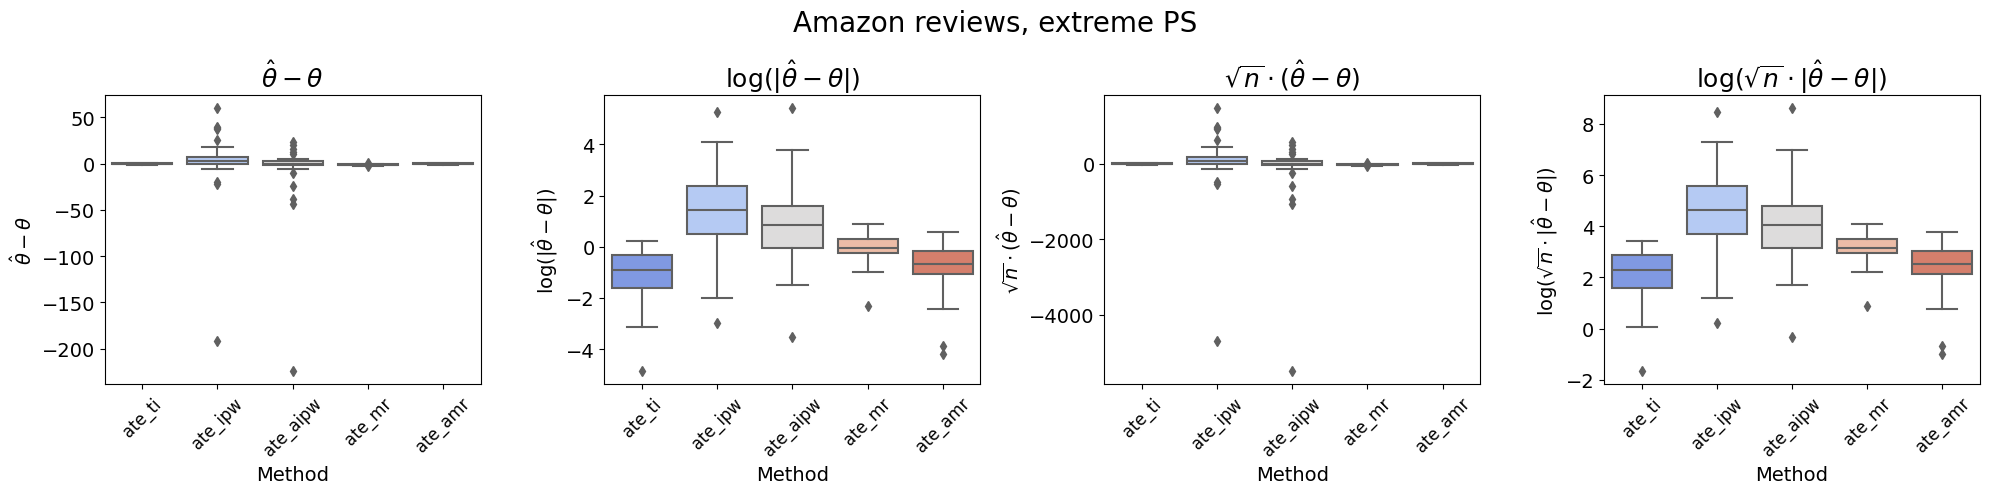

     Method  Mean_Diff   Std_Diff  Mean_Abs_Diff  Std_Abs_Diff       RMSE  \
0    ate_ti  -0.088227   0.566547       0.477028      0.318125   0.573375   
1   ate_ipw   2.549922  30.945212      12.556189     28.398070  31.050092   
2  ate_aipw  -4.996517  33.124139      10.049213     31.956018  33.498863   
3    ate_mr  -1.041891   0.502331       1.056621      0.470558   1.156664   
4   ate_amr  -0.087798   0.741644       0.620515      0.415578   0.746823   

    Std_RMSE  
0   1.133094  
1  61.890424  
2  66.248279  
3   1.004661  
4   1.483288  


In [32]:
# Extract keys and true ATE
ate_results = load('results/music/ate_extreme.joblib')
methods = [ 'ate_ti',  'ate_ipw', 'ate_aipw',  'ate_mr','ate_amr']

true_ate = np.array(ate_results['true_ate'])

# Calculate metrics
n = 600
results = {}
for method in methods:
    estimates = np.array(ate_results[method])
    results[method] = {
        'estimation_bias': estimates - true_ate,
        'abs_bias': np.abs(estimates - true_ate),
        'sqrt_n_bias': np.sqrt(n) * (estimates - true_ate),
        'sqrt_n_abs_bias': np.sqrt(n) * np.abs(estimates - true_ate)
    }

# Prepare DataFrame for plotting
plot_data = []
for method, metrics in results.items():
    for metric_name, values in metrics.items():
        if "abs" in metric_name:  # Apply log only to absolute metrics
            values = values[values > 0]  # Avoid log(0) issues
        plot_data.append(pd.DataFrame({
            'Method': [method] * len(values),
            'Metric': [metric_name] * len(values),
            'Value': np.log(values) if "abs" in metric_name else values
        }))

plot_df = pd.concat(plot_data)

# Adjust method order
plot_df['Method'] = pd.Categorical(plot_df['Method'], categories=methods, ordered=True)

# Define custom titles for each metric
metric_titles = {
    'estimation_bias': r'$\hat{\theta}-\theta$',
    'abs_bias': r'$\log(|\hat{\theta}-\theta|)$',
    'sqrt_n_bias': r'$\sqrt{n} \cdot (\hat{\theta}-\theta)$',
    'sqrt_n_abs_bias': r'$\log(\sqrt{n} \cdot|\hat{\theta}-\theta|)$'
}

# Plot all metrics in a single row with four columns
unique_metrics = plot_df['Metric'].unique()
fig, axes = plt.subplots(1, len(unique_metrics), figsize=(20, 5), sharey=False)

for i, metric in enumerate(unique_metrics):
    metric_df = plot_df[plot_df['Metric'] == metric]
    ax = sns.boxplot(
        data=metric_df,
        x='Method',
        y='Value',
        palette='coolwarm',
        ax=axes[i]
    )
    # Annotate with means
    for j, box in enumerate(ax.artists):
        method = metric_df['Method'].unique()[j]
        metric_values = metric_df[metric_df['Method'] == method]['Value']
        mean_val = metric_values.mean()
        x_pos = box.get_x() + (box.get_width() / 2)
        ax.scatter(x_pos, mean_val, color='white', s=50, edgecolor='black')
    # Set titles and labels
    ax.set_title(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=18)
    ax.set_ylabel(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=14)
    ax.set_xlabel('Method', fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    ax.tick_params(axis='x', labelsize=12, rotation=45)
plt.suptitle('Amazon reviews, extreme PS', fontsize=20)
plt.tight_layout()
plt.show()

# Compute summary statistics
summary_stats = []


for method in methods:
    estimates = np.array(ate_results[method])
    diffs = estimates - true_ate
    abs_diffs = np.abs(diffs)
    mean_diff = np.mean(diffs)
    std_diff = np.std(diffs)
    mean_abs_diff = np.mean(abs_diffs)
    std_abs_diff = np.std(abs_diffs)
    rmse = np.sqrt(np.mean(diffs**2))
    std_rmse = np.std(diffs*2)  # Standard deviation for RMSE approximation

    summary_stats.append({
        'Method': method,
        'Mean_Diff': mean_diff,
        'Std_Diff': std_diff,
        'Mean_Abs_Diff': mean_abs_diff,
        'Std_Abs_Diff': std_abs_diff,
        'RMSE': rmse,
        'Std_RMSE': std_rmse
    })

summary_df = pd.DataFrame(summary_stats)
print(summary_df)


# Let's play around

In [2]:
embeddings = pd.read_json("../data/music/post_music.json", orient="records", lines=True)

In [9]:
def text_trial_single(n=2000, p=768, adjusted_ate=1, unadjusted_ate=2, embeddings=None, simulated_df=None,
                          cross_fit=True, n_folds=5, ps_model='torch_nn',or_model='torch_nn',w_model='kernel_ridge_regression', random_seed=42, stds_return=True, coverage_return=False):
    if p==768:
        ate = unadjusted_ate
    else:
        ate = adjusted_ate
    sampled_df = simulated_df.sample(n=n,replace=False,random_state=random_seed).reset_index()    
    
    # Qmodel
    mod = QNet(batch_size = 64, # batch size for training
           a_weight = 1,  # loss weight for A ~ text
           y_weight = 1,  # loss weight for Y ~ A + text
           mlm_weight=1,  # loss weight for DistlBert
           modeldir='model/train') # directory for saving the best model
    mod.train(sampled_df['text'],  # texts in training data
           sampled_df['T'],     # treatments in training data
          sampled_df['C'],     # confounds in training data, binary
          sampled_df['Y'],     # outcomes in training data
          epochs=1,   # the maximum number of training epochs
          # learning_rate = 2e-5)  # learning rate for the training
          learning_rate = 1e-2) 
    Q0, Q1, A, Y, _ = mod.get_Q(sampled_df['text'], sampled_df['T'], sampled_df['C'], sampled_df['Y'])
    g = get_propensities(A, Q0, Q1, 
                     model_type='GaussianProcessRegression', # choose the nonparametric model
                     kernel=None,    # kernel function for GPR
                     random_state=42) # random seed for GPR
    propen = mod.get_pA(sampled_df['text'], sampled_df['C'])

    att_ti, std_att_ti, _, _ = get_TI_estimator(g, Q0, Q1, A, Y, 
                  error=0.05)[0].values
    ate_ti, std_ate_ti, _, _ = ate_aiptw(np.array(Q0),np.array(Q1),A,Y,g,error_bound=0.05)
    

    # our method
    df = pd.merge(sampled_df, embeddings, on='text', how='inner')
    df.drop(columns=['index','Unnamed: 0','text'],inplace=True)
    df.rename(columns={'C': 'X769','T':'A', 'Y':'y'},inplace=True)
    df['mu0']=Q0
    df['mu1']=Q1
    df['propen']=propen
    if not stds_return:
        ates = single_trial(true_ate=ate, df_full=df, p=p, ps_model=ps_model, or_model=or_model, w_model=w_model, 
            random_seed=random_seed, cross_fit=cross_fit, n_folds=n_folds,stds_return=stds_return, coverage_return=coverage_return)
        all_ate = {'true_ate':ate,
                'ti_att':ti_att,
                'ti_ate':ti_ate,
                'ate_mr':ates['ate_mr'],
                'ate_ipw':ates['ate_ipw'],
                'ate_amr':ates['ate_amr'],
                'ate_aipw':ates['ate_aipw']}
        return all_ate, _
    else:
        ates, stds = single_trial(true_ate=ate, df_full=df, p=p, ps_model=ps_model, or_model=or_model, w_model=w_model, 
            random_seed=random_seed, cross_fit=cross_fit, n_folds=n_folds,stds_return=stds_return, coverage_return=coverage_return)
    
        all_ate = {'true_ate':ate,
                    'att_ti':att_ti,
                    'ate_ti':ate_ti,
                    'ate_mr':ates['ate_mr'],
                    'ate_ipw':ates['ate_ipw'],
                    'ate_amr':ates['ate_amr'],
                    'ate_aipw':ates['ate_aipw']}
        
        all_std = {'std_att_ti': std_att_ti,
                    'std_ate_ti': std_ate_ti,
                    'std_mr': stds['ate_mr'],
                    'std_ipw': stds['ate_ipw'],
                    'std_amr': stds['ate_amr'],
                    'std_aipw': stds['ate_aipw']}
    

        return all_ate, all_std
def text_trial(num_trials=200,n=2000, p=768, adjusted_ate=1, unadjusted_ate=3, embeddings=None, simulated_df=None,
                          cross_fit=True, n_folds=5, ps_model='torch_nn',or_model='torch_nn',w_model='kernel_ridge_regression', random_seed=42, stds_return=True, coverage_return=False):
    ate_results = {
    'true_ate': [],
    'att_ti': [],
    'ate_ti': [],
    'ate_mr': [],
    'ate_ipw': [],
    'ate_amr': [],
    'ate_aipw': []
    }
    std_results = {
        'std_att_ti': [],
        'std_ate_ti': [],
        'std_mr': [],
        'std_ipw': [],
        'std_amr': [],
        'std_aipw': []
    }

    
    for i in tqdm(range(num_trials)):
        if not stds_return:
            single_all_ate = text_trial_single(n=n, p=p, adjusted_ate=adjusted_ate, unadjusted_ate=unadjusted_ate, embeddings=embeddings, simulated_df=simulated_df,
                          cross_fit=cross_fit, n_folds=n_folds, ps_model=ps_model,or_model=or_model,w_model=w_model, random_seed=random_seed+i, stds_return=stds_return, coverage_return=coverage_return)
            for key, value in single_all_ate.items():
                ate_results[key].append(value)
            return ate_results
        else:
            single_all_ate, single_all_std = text_trial_single(n=n, p=p, adjusted_ate=adjusted_ate, unadjusted_ate=unadjusted_ate, embeddings=embeddings, simulated_df=simulated_df,
                          cross_fit=cross_fit, n_folds=n_folds, ps_model=ps_model,or_model=or_model,w_model=w_model, random_seed=random_seed+i, stds_return=stds_return, coverage_return=coverage_return)
            for key, value in single_all_ate.items():
                ate_results[key].append(value)
            for key, value in single_all_std.items():
                std_results[key].append(value)

    return ate_results, std_results
    

In [10]:
raw_df = pd.read_csv('../data/music/music.csv')
simulated_df, offset =run_simulation(raw_df, propensities=[0.8, 0.6], 
                            beta_t=1.0,  # 1.0, 0.0
                            beta_c=50.0, # 50.0, 100.0
                            gamma=1,    # 1.0, 4.0
                            cts=True)    
simulated_df = simulated_df.drop_duplicates(subset='text')
adjusted_ate = ATE_adjusted(simulated_df['C'], simulated_df['T'], simulated_df['Y'])
unadjusted_ate = ATE_unadjusted(simulated_df['T'], simulated_df['Y'])
print('adjusted ATE: ', adjusted_ate)
print('unadjusted ATE: ', unadjusted_ate)


Offset: 0.629293401965372
[0.2, 0.8]
[0.4, 0.6]
adjusted ATE:  1.0049071276143753
unadjusted ATE:  2.069297192109347


In [61]:
simulated_df

,index,Unnamed: 0,text,C,T,Y
0,2,2,"Keith Green, gone far to early in his carreer,...",1,1,-0.214070
1,5,7,Buy the CD. Do not buy the MP3 album. Downlo...,0,0,10.080163
2,25,32,The Master! This is simply great for someone ...,1,1,-1.192678
3,36,46,In the twenty years or so since I have first h...,1,1,-1.702683
4,38,49,It's just as good as when I was a kid. I enjoy...,1,1,-1.604175
...,...,...,...,...,...,...
10680,46002,55950,To be perfectly honest I had not heard of Fran...,1,1,0.255884
10681,46006,55957,We love the Dead South! This album is definite...,1,1,0.714286
10682,46018,55973,the reading of his poems are monotonous.,1,0,-1.926536
10683,46021,55976,I can easily recommend this 13-disc box set of...,1,1,-0.905099


In [64]:
ate_results, std_results = text_trial(num_trials=50,n=1000, p=768, adjusted_ate=adjusted_ate, unadjusted_ate=unadjusted_ate, embeddings=embeddings, simulated_df=simulated_df,
                          cross_fit=True, n_folds=5, ps_model='torch_nn',or_model='original',w_model='kernel_ridge_regression', random_seed=42, stds_return=True, coverage_return=False)
# Define the file path
ate_output_file = "results/music/ate_change_config.joblib"
std_output_file = "results/music/std_change_config.joblib"

# Ensure the directory exists
os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
os.makedirs(os.path.dirname(std_output_file), exist_ok=True)

# Save the results using joblib
dump(ate_results, ate_output_file)
print(f"Results saved to {ate_output_file}")
dump(std_results, std_output_file)
print(f"Results saved to {std_output_file}")

  0%|          | 0/50 [00:00<?, ?it/s]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


A Validation loss: 0.9078748273849487
Y Validation loss: 10.55786922454834
Validation loss: 11.465744051933289
A accuracy: 0.685


  2%|▏         | 1/50 [02:09<1:45:31, 129.21s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


A Validation loss: 0.8264774107933044
Y Validation loss: 11.705929985046387
Validation loss: 12.53240739583969
A accuracy: 0.61


  4%|▍         | 2/50 [04:21<1:44:52, 131.09s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


A Validation loss: 1.279247703552246
Y Validation loss: 16.44691982269287
Validation loss: 17.726167526245117
A accuracy: 0.355


  6%|▌         | 3/50 [06:21<1:38:31, 125.79s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


A Validation loss: 0.7325143098831177
Y Validation loss: 13.498251953125
Validation loss: 14.230766263008118
A accuracy: 0.665


  8%|▊         | 4/50 [08:15<1:33:02, 121.35s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


A Validation loss: 0.8267542099952698
Y Validation loss: 11.733629989624024
Validation loss: 12.560384199619294
A accuracy: 0.615


 10%|█         | 5/50 [10:10<1:29:17, 119.05s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


A Validation loss: 1.0489075326919555
Y Validation loss: 11.475708541870118
Validation loss: 12.524616074562074
A accuracy: 0.65


 12%|█▏        | 6/50 [12:01<1:25:20, 116.38s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


A Validation loss: 0.8036443948745727
Y Validation loss: 14.12904037475586
Validation loss: 14.932684769630432
A accuracy: 0.62


 14%|█▍        | 7/50 [14:05<1:25:11, 118.87s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


A Validation loss: 1.0891510105133058
Y Validation loss: 14.469318046569825
Validation loss: 15.55846905708313
A accuracy: 0.35


 16%|█▌        | 8/50 [16:09<1:24:12, 120.29s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]


A Validation loss: 0.9706254577636719
Y Validation loss: 10.831632690429688
Validation loss: 11.80225814819336
A accuracy: 0.395


 18%|█▊        | 9/50 [18:24<1:25:26, 125.03s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


A Validation loss: 0.9364235734939576
Y Validation loss: 11.253203506469726
Validation loss: 12.189627079963683
A accuracy: 0.35


 20%|██        | 10/50 [20:20<1:21:34, 122.35s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]


A Validation loss: 0.6665947270393372
Y Validation loss: 14.459816217422485
Validation loss: 15.126410944461822
A accuracy: 0.615


 22%|██▏       | 11/50 [35:36<3:57:22, 365.18s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


A Validation loss: 1.3492990589141847
Y Validation loss: 10.632775459289551
Validation loss: 11.982074518203735
A accuracy: 0.64


 24%|██▍       | 12/50 [37:44<3:05:28, 292.85s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:03<00:00,  1.33it/s]


A Validation loss: 1.6264732789993286
Y Validation loss: 16.87007122039795
Validation loss: 18.496544499397277
A accuracy: 0.635


 26%|██▌       | 13/50 [39:52<2:29:55, 243.12s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


A Validation loss: 1.4776880836486816
Y Validation loss: 14.055729255676269
Validation loss: 15.53341733932495
A accuracy: 0.355


 28%|██▊       | 14/50 [41:57<2:04:27, 207.44s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


A Validation loss: 0.6712660455703735
Y Validation loss: 18.011031799316406
Validation loss: 18.68229784488678
A accuracy: 0.64


 30%|███       | 15/50 [44:08<1:47:25, 184.17s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


A Validation loss: 0.675129098892212
Y Validation loss: 14.808243713378907
Validation loss: 15.483372812271119
A accuracy: 0.615


 32%|███▏      | 16/50 [46:02<1:32:28, 163.20s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]


A Validation loss: 0.6784052753448486
Y Validation loss: 12.961592712402343
Validation loss: 13.639997987747192
A accuracy: 0.6


 34%|███▍      | 17/50 [48:18<1:25:17, 155.08s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


A Validation loss: 0.6321054482460022
Y Validation loss: 17.4244474029541
Validation loss: 18.056552851200102
A accuracy: 0.705


 36%|███▌      | 18/50 [50:23<1:17:46, 145.83s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


A Validation loss: 1.675776982307434
Y Validation loss: 11.135052490234376
Validation loss: 12.81082947254181
A accuracy: 0.38


 38%|███▊      | 19/50 [52:19<1:10:50, 137.12s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


A Validation loss: 1.3759502744674683
Y Validation loss: 13.52457633972168
Validation loss: 14.900526614189149
A accuracy: 0.64


 40%|████      | 20/50 [54:16<1:05:28, 130.94s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]


A Validation loss: 0.9123856963217258
Y Validation loss: 15.332578201293945
Validation loss: 16.24496389761567
A accuracy: 0.7


 42%|████▏     | 21/50 [56:14<1:01:23, 127.01s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


A Validation loss: 1.121444501876831
Y Validation loss: 13.395141983032227
Validation loss: 14.516586484909059
A accuracy: 0.395


 44%|████▍     | 22/50 [58:08<57:30, 123.24s/it]  Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


A Validation loss: 1.395749225616455
Y Validation loss: 15.440910453796386
Validation loss: 16.83665967941284
A accuracy: 0.405


 46%|████▌     | 23/50 [1:00:11<55:24, 123.12s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


A Validation loss: 0.6110669910907746
Y Validation loss: 14.48947998046875
Validation loss: 15.100546971559526
A accuracy: 0.705


 48%|████▊     | 24/50 [1:02:05<52:10, 120.41s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


A Validation loss: 0.7746473383903504
Y Validation loss: 15.060050201416015
Validation loss: 15.834697539806365
A accuracy: 0.41


 50%|█████     | 25/50 [1:04:00<49:27, 118.68s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]


A Validation loss: 0.5842965841293335
Y Validation loss: 17.09874008178711
Validation loss: 17.683036665916443
A accuracy: 0.73


 52%|█████▏    | 26/50 [1:06:05<48:16, 120.69s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


A Validation loss: 0.9287024116516114
Y Validation loss: 14.424029655456543
Validation loss: 15.352732067108155
A accuracy: 0.345


 54%|█████▍    | 27/50 [1:08:07<46:26, 121.16s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


A Validation loss: 0.6931750988960266
Y Validation loss: 18.243684234619142
Validation loss: 18.93685933351517
A accuracy: 0.335


 56%|█████▌    | 28/50 [1:10:07<44:15, 120.69s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]


A Validation loss: 0.6554358768463134
Y Validation loss: 12.876173400878907
Validation loss: 13.53160927772522
A accuracy: 0.645


 58%|█████▊    | 29/50 [1:12:01<41:35, 118.81s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


A Validation loss: 1.144822463989258
Y Validation loss: 13.410729904174804
Validation loss: 14.555552368164062
A accuracy: 0.6


 60%|██████    | 30/50 [1:13:56<39:09, 117.49s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


A Validation loss: 0.6646137189865112
Y Validation loss: 14.001622924804687
Validation loss: 14.666236643791198
A accuracy: 0.68


 62%|██████▏   | 31/50 [1:15:50<36:51, 116.39s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


A Validation loss: 2.460289659500122
Y Validation loss: 14.192103462219238
Validation loss: 16.65239312171936
A accuracy: 0.355


 64%|██████▍   | 32/50 [1:17:49<35:13, 117.41s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


A Validation loss: 0.7146691465377808
Y Validation loss: 17.336899337768553
Validation loss: 18.051568484306333
A accuracy: 0.615


 66%|██████▌   | 33/50 [1:19:55<33:55, 119.74s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


A Validation loss: 0.7884947276115417
Y Validation loss: 15.329601287841797
Validation loss: 16.11809601545334
A accuracy: 0.385


 68%|██████▊   | 34/50 [1:21:55<32:00, 120.03s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


A Validation loss: 0.9552066278457642
Y Validation loss: 13.790083923339843
Validation loss: 14.745290551185606
A accuracy: 0.355


 70%|███████   | 35/50 [1:24:08<30:54, 123.67s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


A Validation loss: 0.7866446352005005
Y Validation loss: 14.379471626281738
Validation loss: 15.16611626148224
A accuracy: 0.6


 72%|███████▏  | 36/50 [1:26:02<28:12, 120.90s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


A Validation loss: 0.673556547164917
Y Validation loss: 14.408822135925293
Validation loss: 15.08237868309021
A accuracy: 0.615


 74%|███████▍  | 37/50 [1:27:56<25:45, 118.87s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


A Validation loss: 1.0100624179840088
Y Validation loss: 15.79079231262207
Validation loss: 16.80085473060608
A accuracy: 0.67


 76%|███████▌  | 38/50 [1:30:00<24:03, 120.30s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]


A Validation loss: 1.1986712622642517
Y Validation loss: 15.883292961120606
Validation loss: 17.08196422338486
A accuracy: 0.645


 78%|███████▊  | 39/50 [1:31:54<21:43, 118.49s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


A Validation loss: 0.7542335319519043
Y Validation loss: 12.782227706909179
Validation loss: 13.536461238861083
A accuracy: 0.395


 80%|████████  | 40/50 [1:33:55<19:52, 119.29s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


A Validation loss: 0.6595019912719726
Y Validation loss: 14.215339460372924
Validation loss: 14.874841451644897
A accuracy: 0.635


 82%|████████▏ | 41/50 [1:35:51<17:43, 118.17s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


A Validation loss: 0.6617532682418823
Y Validation loss: 10.390613794326782
Validation loss: 11.052367062568665
A accuracy: 0.64


 84%|████████▍ | 42/50 [1:37:45<15:36, 117.02s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


A Validation loss: 0.9556382274627686
Y Validation loss: 11.765839233398438
Validation loss: 12.721477460861207
A accuracy: 0.68


 86%|████████▌ | 43/50 [1:39:49<13:54, 119.15s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


A Validation loss: 1.774835968017578
Y Validation loss: 10.728091697692872
Validation loss: 12.50292766571045
A accuracy: 0.375


 88%|████████▊ | 44/50 [1:41:53<12:03, 120.51s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


A Validation loss: 1.071295852661133
Y Validation loss: 15.627521781921386
Validation loss: 16.698817634582518
A accuracy: 0.63


 90%|█████████ | 45/50 [1:43:48<09:54, 118.97s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.36it/s]


A Validation loss: 0.6639090991020202
Y Validation loss: 12.712207679748536
Validation loss: 13.376116778850555
A accuracy: 0.625


 92%|█████████▏| 46/50 [1:45:45<07:52, 118.25s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


A Validation loss: 1.04196072101593
Y Validation loss: 13.859631099700927
Validation loss: 14.901591820716856
A accuracy: 0.6


 94%|█████████▍| 47/50 [1:47:56<06:06, 122.17s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


A Validation loss: 0.7824911999702454
Y Validation loss: 12.336854705810547
Validation loss: 13.119345905780792
A accuracy: 0.685


 96%|█████████▌| 48/50 [1:49:51<04:00, 120.06s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


A Validation loss: 1.6480904293060303
Y Validation loss: 14.068819274902344
Validation loss: 15.716909704208375
A accuracy: 0.625


 98%|█████████▊| 49/50 [1:51:47<01:58, 118.91s/it]Some weights of CausalQNet were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.0.0.bias', 'Q_cls.0.0.weight', 'Q_cls.0.2.bias', 'Q_cls.0.2.weight', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.1.2.bias', 'Q_cls.1.2.weight', 'g_hat.bias', 'g_hat.weight', 'vocab_projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


A Validation loss: 1.2976810979843139
Y Validation loss: 17.532705230712892
Validation loss: 18.830386328697205
A accuracy: 0.37


100%|██████████| 50/50 [1:53:50<00:00, 136.62s/it]

Results saved to results/music/ate_change_config.joblib
Results saved to results/music/std_change_config.joblib


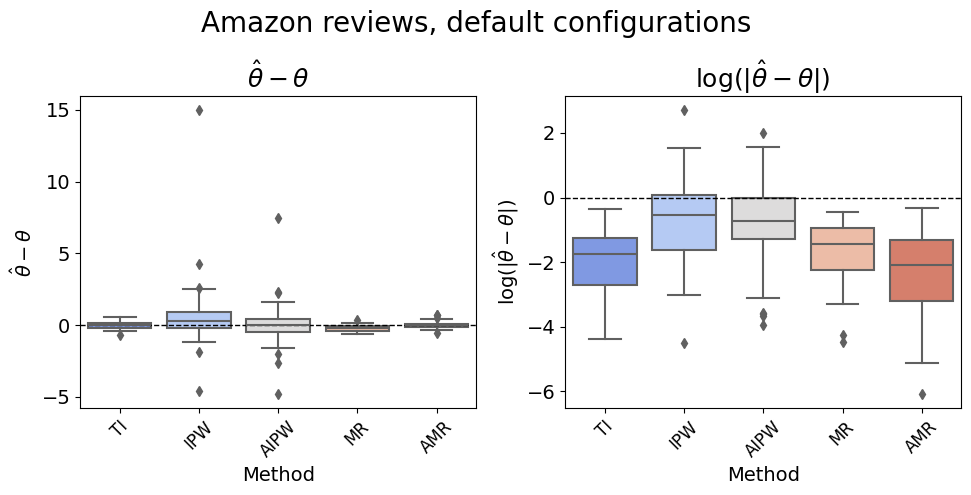

  Method  Mean_Diff  Std_Diff  Mean_Abs_Diff  Std_Abs_Diff      RMSE  Std_RMSE
0     TI  -0.026290  0.244684       0.190726      0.155515  0.246092  0.489367
1    IPW   0.623477  2.386634       1.122118      2.196725  2.466728  4.773269
2   AIPW   0.055020  1.548198       0.898672      1.261877  1.549176  3.096396
3     MR  -0.226189  0.217865       0.256797      0.180780  0.314048  0.435729
4    AMR   0.019224  0.246390       0.177259      0.172212  0.247139  0.492780


In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import load

# -----------------------
# Load data
# -----------------------
ate_results = load('results/music/ate_change_config.joblib')

# Original list of methods
methods = ['att_ti', 'ate_ipw', 'ate_aipw', 'ate_mr', 'ate_amr']

# Map each method to a nicer display name
short_methods = {
    'att_ti':   'TI',
    'ate_ipw':  'IPW',
    'ate_aipw': 'AIPW',
    'ate_mr':   'MR',
    'ate_amr':  'AMR'
}

# Set the order in which you want these short names to appear
ordered_short_methods = ['TI', 'IPW', 'AIPW', 'MR', 'AMR']

# Extract the true ATE
true_ate = np.array(ate_results['true_ate'])

# -----------------------
# Calculate metrics
# -----------------------
n = 1000
results = {}

for method in methods:
    estimates = np.array(ate_results[method])
    results[method] = {
        'estimation_bias': estimates - true_ate,
        'abs_bias': np.abs(estimates - true_ate),
        # 'sqrt_n_bias': np.sqrt(n) * (estimates - true_ate),
        # 'sqrt_n_abs_bias': np.sqrt(n) * np.abs(estimates - true_ate)
    }

# -----------------------
# Prepare DataFrame for plotting
# -----------------------
plot_data = []

for method, metrics in results.items():
    # Use the short (capitalized) name instead of the raw method
    short_name = short_methods[method]
    for metric_name, values in metrics.items():
        if "abs" in metric_name:  # Apply log only to absolute metrics
            # Avoid log(0) issues
            values = values[values > 0]  
        plot_data.append(pd.DataFrame({
            'Method': [short_name] * len(values),
            'Metric': [metric_name] * len(values),
            'Value': np.log(values) if "abs" in metric_name else values
        }))

plot_df = pd.concat(plot_data, ignore_index=True)

# Adjust method order using the capitalized names
plot_df['Method'] = pd.Categorical(
    plot_df['Method'], 
    categories=ordered_short_methods,
    ordered=True
)

# -----------------------
# Define custom titles for each metric
# -----------------------
metric_titles = {
    'estimation_bias': r'$\hat{\theta}-\theta$',
    'abs_bias':        r'$\log(|\hat{\theta}-\theta|)$',
    # 'sqrt_n_bias':    r'$\sqrt{n} \cdot (\hat{\theta}-\theta)$',
    # 'sqrt_n_abs_bias':r'$\log(\sqrt{n} \cdot|\hat{\theta}-\theta|)$'
}

# -----------------------
# Plot metrics
# -----------------------
unique_metrics = plot_df['Metric'].unique()
fig, axes = plt.subplots(1, len(unique_metrics), figsize=(10, 5), sharey=False)

for i, metric in enumerate(unique_metrics):
    metric_df = plot_df[plot_df['Metric'] == metric]
    ax = sns.boxplot(
        data=metric_df,
        x='Method',
        y='Value',
        palette='coolwarm',  # or 'Set2', 'Blues', etc.
        ax=axes[i]
    )
    # Annotate with means
    for j, box in enumerate(ax.artists):
        # Identify which short method corresponds to this box
        short_method_name = metric_df['Method'].unique()[j]
        metric_values = metric_df[metric_df['Method'] == short_method_name]['Value']
        mean_val = metric_values.mean()
        x_pos = box.get_x() + (box.get_width() / 2)
        ax.scatter(x_pos, mean_val, color='white', s=50, edgecolor='black')
    
    # Set titles and labels
    ax.set_title(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=18)
    ax.set_ylabel(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=14)
    ax.set_xlabel('Method', fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    ax.tick_params(axis='x', labelsize=12, rotation=45)
    
    # Horizontal dashed line at y=0
    ax.axhline(0, color='black', linestyle='--', linewidth=1)

plt.suptitle('Amazon reviews, default configurations', fontsize=20)
plt.tight_layout()
plt.show()

# -----------------------
# Compute summary statistics
# -----------------------
summary_stats = []

for method in methods:
    estimates = np.array(ate_results[method])
    diffs = estimates - true_ate
    abs_diffs = np.abs(diffs)
    
    mean_diff = np.mean(diffs)
    std_diff = np.std(diffs)
    mean_abs_diff = np.mean(abs_diffs)
    std_abs_diff = np.std(abs_diffs)
    rmse = np.sqrt(np.mean(diffs**2))
    
    # For completeness; not a common definition to use std of RMSE, but carried over from your snippet
    std_rmse = np.std(diffs * 2)  
    
    summary_stats.append({
        'Method': short_methods[method],  # Use the short/capitalized name here
        'Mean_Diff': mean_diff,
        'Std_Diff': std_diff,
        'Mean_Abs_Diff': mean_abs_diff,
        'Std_Abs_Diff': std_abs_diff,
        'RMSE': rmse,
        'Std_RMSE': std_rmse
    })

summary_df = pd.DataFrame(summary_stats)
print(summary_df)


# Experiment of changing potential outcome model for Qmod

In [12]:
raw_df = pd.read_csv('../data/music/music.csv')
simulated_df, offset =run_simulation(raw_df, propensities=[0.8, 0.6], 
                            beta_t=1.0,  # 1.0, 0.0
                            beta_c=50.0, # 50.0, 100.0
                            gamma=1,    # 1.0, 4.0
                            cts=True)    
simulated_df = simulated_df.drop_duplicates(subset='text')
adjusted_ate = ATE_adjusted(simulated_df['C'], simulated_df['T'], simulated_df['Y'])
unadjusted_ate = ATE_unadjusted(simulated_df['T'], simulated_df['Y'])
print('adjusted ATE: ', adjusted_ate)
print('unadjusted ATE: ', unadjusted_ate)


Offset: 0.629293401965372
[0.2, 0.8]
[0.4, 0.6]
adjusted ATE:  0.9619616701880369
unadjusted ATE:  2.0336679632481154


In [28]:
def text_trial_single_v2(n=2000, p=768, adjusted_ate=1, unadjusted_ate=2, embeddings=None, simulated_df=None,
                          cross_fit=True, n_folds=5, ps_model='torch_nn',or_model='torch_nn',w_model='kernel_ridge_regression', random_seed=42, stds_return=True, coverage_return=False):
    if p==768:
        ate = unadjusted_ate
    else:
        ate = adjusted_ate
    sampled_df = simulated_df.sample(n=n,replace=False,random_state=random_seed).reset_index()  
    

    # our method
    df = pd.merge(sampled_df, embeddings, on='text', how='inner')
    df.drop(columns=['index','Unnamed: 0','text'],inplace=True)
    df.rename(columns={'C': 'X769','T':'A', 'Y':'y'},inplace=True)
    if not stds_return:
        df_result,ates = single_text_trial(true_ate=ate, df_full=df, p=p, ps_model=ps_model, or_model=or_model, w_model=w_model, 
            random_seed=random_seed, cross_fit=cross_fit, n_folds=n_folds,stds_return=stds_return, coverage_return=coverage_return)
        Q0 = df_result['hat_mu0']
        Q1 = df_result['hat_mu1']
        A = df_result['A']
        Y = df_result['y']
        g = get_propensities(df_result['A'], Q0, Q1, 
                     model_type='GaussianProcessRegression', # choose the nonparametric model
                     kernel=None,    # kernel function for GPR
                     random_state=42) # random seed for GPR 
        att_ti, std_att_ti, _, _ = get_TI_estimator(g, Q0, Q1, A, Y, 
                  error=0.05)[0].values
        ate_ti, std_ate_ti, _, _ = ate_aiptw(np.array(Q0),np.array(Q1),A,Y,g,error_bound=0.05)
        all_ate = {'true_ate':ate,
                'ti_att':ti_att,
                'ti_ate':ti_ate,
                'ate_mr':ates['ate_mr'],
                'ate_ipw':ates['ate_ipw'],
                'ate_amr':ates['ate_amr'],
                'ate_aipw':ates['ate_aipw']}
        return all_ate
    else:
        df_result, ates, stds = single_text_trial(true_ate=ate, df_full=df, p=p, ps_model=ps_model, or_model=or_model, w_model=w_model, 
            random_seed=random_seed, cross_fit=cross_fit, n_folds=n_folds,stds_return=stds_return, coverage_return=coverage_return)
        Q0 = df_result['hat_mu0']
        Q1 = df_result['hat_mu1']
        A = df_result['A']
        Y = df_result['y']
        g = get_propensities(A, Q0, Q1, 
                     model_type='GaussianProcessRegression', # choose the nonparametric model
                     kernel=None,    # kernel function for GPR
                     random_state=42) # random seed for GPR 
        att_ti, std_att_ti, _, _ = get_TI_estimator(g, Q0, Q1, A, Y, 
                  error=0.05)[0].values
        ate_ti, std_ate_ti, _, _ = ate_aiptw(np.array(Q0),np.array(Q1),A,Y,g,error_bound=0.05)
        all_ate = {'true_ate':ate,
                    'att_ti':att_ti,
                    'ate_ti':ate_ti,
                    'ate_mr':ates['ate_mr'],
                    'ate_ipw':ates['ate_ipw'],
                    'ate_amr':ates['ate_amr'],
                    'ate_aipw':ates['ate_aipw']}
        
        all_std = {'std_att_ti': std_att_ti,
                    'std_ate_ti': std_ate_ti,
                    'std_mr': stds['ate_mr'],
                    'std_ipw': stds['ate_ipw'],
                    'std_amr': stds['ate_amr'],
                    'std_aipw': stds['ate_aipw']}
    

        return all_ate, all_std
def text_trial_v2(num_trials=200,n=2000, p=768, adjusted_ate=1, unadjusted_ate=3, embeddings=None, simulated_df=None,
                          cross_fit=True, n_folds=5, ps_model='torch_nn',or_model='torch_nn',w_model='kernel_ridge_regression', random_seed=42, stds_return=True, coverage_return=False):
    ate_results = {
    'true_ate': [],
    'att_ti': [],
    'ate_ti': [],
    'ate_mr': [],
    'ate_ipw': [],
    'ate_amr': [],
    'ate_aipw': []
    }
    std_results = {
        'std_att_ti': [],
        'std_ate_ti': [],
        'std_mr': [],
        'std_ipw': [],
        'std_amr': [],
        'std_aipw': []
    }

    
    for i in tqdm(range(num_trials)):
        if not stds_return:
            single_all_ate, = text_trial_single_v2(n=n, p=p, adjusted_ate=adjusted_ate, unadjusted_ate=unadjusted_ate, embeddings=embeddings, simulated_df=simulated_df,
                          cross_fit=cross_fit, n_folds=n_folds, ps_model=ps_model,or_model=or_model,w_model=w_model, random_seed=random_seed+i, stds_return=stds_return, coverage_return=coverage_return)
            for key, value in single_all_ate.items():
                ate_results[key].append(value)
            return ate_results
        else:
            single_all_ate, single_all_std = text_trial_single_v2(n=n, p=p, adjusted_ate=adjusted_ate, unadjusted_ate=unadjusted_ate, embeddings=embeddings, simulated_df=simulated_df,
                          cross_fit=cross_fit, n_folds=n_folds, ps_model=ps_model,or_model=or_model,w_model=w_model, random_seed=random_seed+i, stds_return=stds_return, coverage_return=coverage_return)
            for key, value in single_all_ate.items():
                ate_results[key].append(value)
            for key, value in single_all_std.items():
                std_results[key].append(value)

    return ate_results, std_results
    

In [100]:
ate_results, std_results = text_trial_v2(num_trials=50,n=1000, p=768, adjusted_ate=adjusted_ate, unadjusted_ate=unadjusted_ate, embeddings=embeddings, simulated_df=simulated_df,
                          cross_fit=True, n_folds=5, ps_model='torch_nn',or_model='torch_nn',w_model='kernel_ridge_regression', random_seed=42, stds_return=True, coverage_return=False)
# Define the file path
ate_output_file = "results/music/ate_nn.joblib"
std_output_file = "results/music/std_nn.joblib"

# Ensure the directory exists
os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
os.makedirs(os.path.dirname(std_output_file), exist_ok=True)

# Save the results using joblib
dump(ate_results, ate_output_file)
print(f"Results saved to {ate_output_file}")
dump(std_results, std_output_file)
print(f"Results saved to {std_output_file}")

100%|██████████| 50/50 [21:47<00:00, 26.15s/it]

Results saved to results/music/ate_nn.joblib
Results saved to results/music/std_nn.joblib


In [15]:
ate_results, std_results = text_trial_v2(num_trials=200,n=1000, p=768, adjusted_ate=adjusted_ate, unadjusted_ate=unadjusted_ate, embeddings=embeddings, simulated_df=simulated_df,
                          cross_fit=True, n_folds=5, ps_model='torch_nn',or_model='torch_nn',w_model='kernel_ridge_regression', random_seed=42, stds_return=True, coverage_return=False)
# # Define the file path
# ate_output_file = "results/music/ate_nn.joblib"
# std_output_file = "results/music/std_nn.joblib"

# # Ensure the directory exists
# os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
# os.makedirs(os.path.dirname(std_output_file), exist_ok=True)

# # Save the results using joblib
# dump(ate_results, ate_output_file)
# print(f"Results saved to {ate_output_file}")
# dump(std_results, std_output_file)
# print(f"Results saved to {std_output_file}")

100%|██████████| 200/200 [1:25:37<00:00, 25.69s/it]


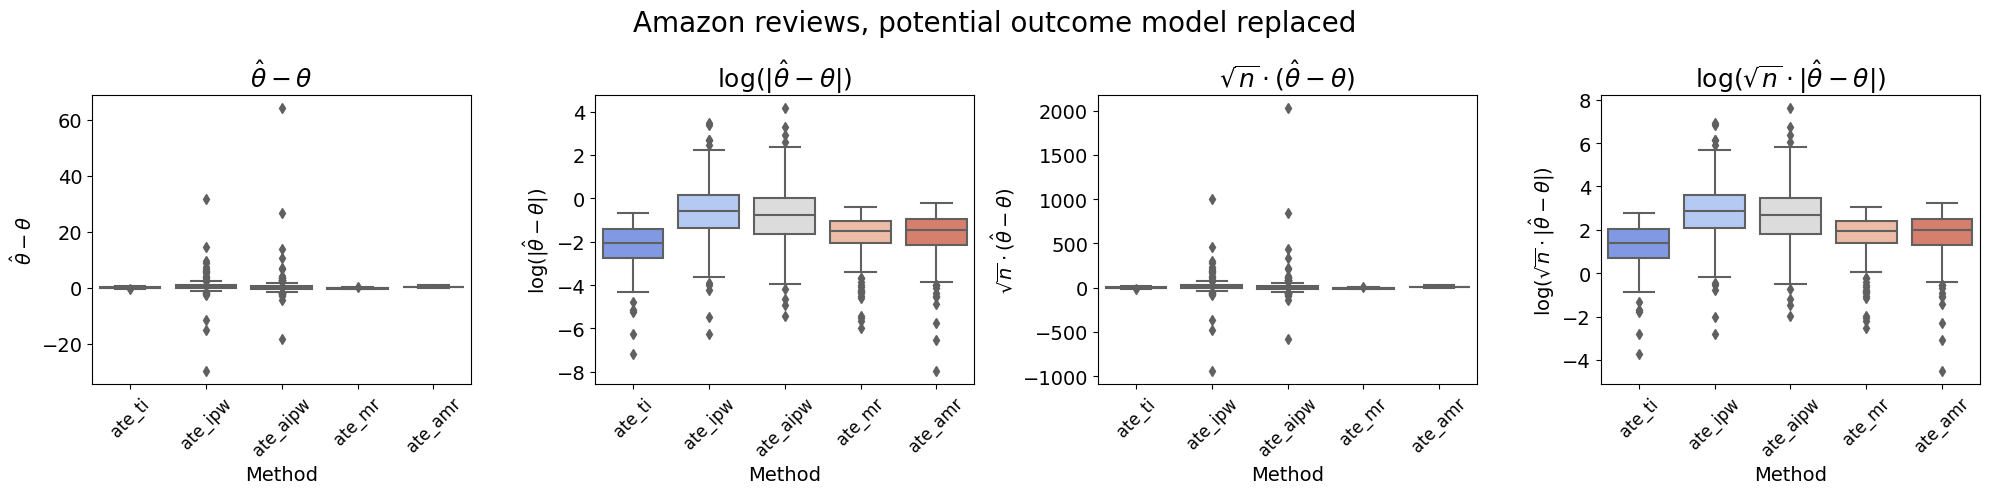

     Method  Mean_Diff  Std_Diff  Mean_Abs_Diff  Std_Abs_Diff      RMSE  \
0    ate_ti  -0.000628  0.199045       0.160224      0.118100  0.199046   
1   ate_ipw   0.651672  3.877123       1.504535      3.632236  3.931509   
2  ate_aipw   0.614871  5.349173       1.453311      5.184554  5.384395   
3    ate_mr  -0.223576  0.187415       0.243802      0.160222  0.291737   
4   ate_amr   0.237396  0.229308       0.270707      0.188829  0.330059   

    Std_RMSE  
0   0.398090  
1   7.754247  
2  10.698345  
3   0.374829  
4   0.458616  


In [16]:
# # Extract keys and true ATE
# ate_results = load('results/music/ate_extreme.joblib')
methods = [ 'ate_ti',  'ate_ipw', 'ate_aipw',  'ate_mr','ate_amr']

true_ate = np.array(ate_results['true_ate'])

# Calculate metrics
n = 1000
results = {}
for method in methods:
    estimates = np.array(ate_results[method])
    results[method] = {
        'estimation_bias': estimates - true_ate,
        'abs_bias': np.abs(estimates - true_ate),
        'sqrt_n_bias': np.sqrt(n) * (estimates - true_ate),
        'sqrt_n_abs_bias': np.sqrt(n) * np.abs(estimates - true_ate)
    }

# Prepare DataFrame for plotting
plot_data = []
for method, metrics in results.items():
    for metric_name, values in metrics.items():
        if "abs" in metric_name:  # Apply log only to absolute metrics
            values = values[values > 0]  # Avoid log(0) issues
        plot_data.append(pd.DataFrame({
            'Method': [method] * len(values),
            'Metric': [metric_name] * len(values),
            'Value': np.log(values) if "abs" in metric_name else values
        }))

plot_df = pd.concat(plot_data)

# Adjust method order
plot_df['Method'] = pd.Categorical(plot_df['Method'], categories=methods, ordered=True)

# Define custom titles for each metric
metric_titles = {
    'estimation_bias': r'$\hat{\theta}-\theta$',
    'abs_bias': r'$\log(|\hat{\theta}-\theta|)$',
    'sqrt_n_bias': r'$\sqrt{n} \cdot (\hat{\theta}-\theta)$',
    'sqrt_n_abs_bias': r'$\log(\sqrt{n} \cdot|\hat{\theta}-\theta|)$'
}

# Plot all metrics in a single row with four columns
unique_metrics = plot_df['Metric'].unique()
fig, axes = plt.subplots(1, len(unique_metrics), figsize=(20, 5), sharey=False)

for i, metric in enumerate(unique_metrics):
    metric_df = plot_df[plot_df['Metric'] == metric]
    ax = sns.boxplot(
        data=metric_df,
        x='Method',
        y='Value',
        palette='coolwarm',
        ax=axes[i]
    )
    # Annotate with means
    for j, box in enumerate(ax.artists):
        method = metric_df['Method'].unique()[j]
        metric_values = metric_df[metric_df['Method'] == method]['Value']
        mean_val = metric_values.mean()
        x_pos = box.get_x() + (box.get_width() / 2)
        ax.scatter(x_pos, mean_val, color='white', s=50, edgecolor='black')
    # Set titles and labels
    ax.set_title(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=18)
    ax.set_ylabel(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=14)
    ax.set_xlabel('Method', fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    ax.tick_params(axis='x', labelsize=12, rotation=45)
plt.suptitle('Amazon reviews, potential outcome model replaced', fontsize=20)
plt.tight_layout()
plt.show()

# Compute summary statistics
summary_stats = []


for method in methods:
    estimates = np.array(ate_results[method])
    diffs = estimates - true_ate
    abs_diffs = np.abs(diffs)
    mean_diff = np.mean(diffs)
    std_diff = np.std(diffs)
    mean_abs_diff = np.mean(abs_diffs)
    std_abs_diff = np.std(abs_diffs)
    rmse = np.sqrt(np.mean(diffs**2))
    std_rmse = np.std(diffs*2)  # Standard deviation for RMSE approximation

    summary_stats.append({
        'Method': method,
        'Mean_Diff': mean_diff,
        'Std_Diff': std_diff,
        'Mean_Abs_Diff': mean_abs_diff,
        'Std_Abs_Diff': std_abs_diff,
        'RMSE': rmse,
        'Std_RMSE': std_rmse
    })

summary_df = pd.DataFrame(summary_stats)
print(summary_df)


In [17]:
def text_trial_single_v2(n=2000, p=768, adjusted_ate=1, unadjusted_ate=2, embeddings=None, simulated_df=None,
                          cross_fit=True, n_folds=5, ps_model='torch_nn',or_model='torch_nn',w_model='kernel_ridge_regression', random_seed=42, stds_return=True, coverage_return=False):
    if p==768:
        ate = unadjusted_ate
    else:
        ate = adjusted_ate
    sampled_df = simulated_df.sample(n=n,replace=False,random_state=random_seed).reset_index()  
    

    # our method
    df = pd.merge(sampled_df, embeddings, on='text', how='inner')
    df.drop(columns=['index','Unnamed: 0','text'],inplace=True)
    df.rename(columns={'C': 'X769','T':'A', 'Y':'y'},inplace=True)
    if not stds_return:
        df_result,ates = single_text_trial(true_ate=ate, df_full=df, p=p, ps_model=ps_model, or_model=or_model, w_model=w_model, 
            random_seed=random_seed, cross_fit=cross_fit, n_folds=n_folds,stds_return=stds_return, coverage_return=coverage_return)
        Q0 = df_result['hat_mu0']
        Q1 = df_result['hat_mu1']
        A = df_result['A']
        Y = df_result['y']
        g = get_propensities(df_result['A'], Q0, Q1, 
                     model_type='KNearestNeighbors', # choose the nonparametric model
                     kernel=None,    # kernel function for GPR
                     random_state=42) # random seed for GPR 
        att_ti, std_att_ti, _, _ = get_TI_estimator(g, Q0, Q1, A, Y, 
                  error=0.05)[0].values
        ate_ti, std_ate_ti, _, _ = ate_aiptw(np.array(Q0),np.array(Q1),A,Y,g,error_bound=0.05)
        all_ate = {'true_ate':ate,
                'ti_att':ti_att,
                'ti_ate':ti_ate,
                'ate_mr':ates['ate_mr'],
                'ate_ipw':ates['ate_ipw'],
                'ate_amr':ates['ate_amr'],
                'ate_aipw':ates['ate_aipw']}
        return all_ate
    else:
        df_result, ates, stds = single_text_trial(true_ate=ate, df_full=df, p=p, ps_model=ps_model, or_model=or_model, w_model=w_model, 
            random_seed=random_seed, cross_fit=cross_fit, n_folds=n_folds,stds_return=stds_return, coverage_return=coverage_return)
        Q0 = df_result['hat_mu0']
        Q1 = df_result['hat_mu1']
        A = df_result['A']
        Y = df_result['y']
        g = get_propensities(A, Q0, Q1, 
                     model_type='KNearestNeighbors', # choose the nonparametric model
                     kernel=None,    # kernel function for GPR
                     random_state=42) # random seed for GPR 
        att_ti, std_att_ti, _, _ = get_TI_estimator(g, Q0, Q1, A, Y, 
                  error=0.05)[0].values
        ate_ti, std_ate_ti, _, _ = ate_aiptw(np.array(Q0),np.array(Q1),A,Y,g,error_bound=0.05)
        all_ate = {'true_ate':ate,
                    'att_ti':att_ti,
                    'ate_ti':ate_ti,
                    'ate_mr':ates['ate_mr'],
                    'ate_ipw':ates['ate_ipw'],
                    'ate_amr':ates['ate_amr'],
                    'ate_aipw':ates['ate_aipw']}
        
        all_std = {'std_att_ti': std_att_ti,
                    'std_ate_ti': std_ate_ti,
                    'std_mr': stds['ate_mr'],
                    'std_ipw': stds['ate_ipw'],
                    'std_amr': stds['ate_amr'],
                    'std_aipw': stds['ate_aipw']}
    

        return all_ate, all_std
def text_trial_v2(num_trials=200,n=2000, p=768, adjusted_ate=1, unadjusted_ate=3, embeddings=None, simulated_df=None,
                          cross_fit=True, n_folds=5, ps_model='torch_nn',or_model='torch_nn',w_model='kernel_ridge_regression', random_seed=42, stds_return=True, coverage_return=False):
    ate_results = {
    'true_ate': [],
    'att_ti': [],
    'ate_ti': [],
    'ate_mr': [],
    'ate_ipw': [],
    'ate_amr': [],
    'ate_aipw': []
    }
    std_results = {
        'std_att_ti': [],
        'std_ate_ti': [],
        'std_mr': [],
        'std_ipw': [],
        'std_amr': [],
        'std_aipw': []
    }

    
    for i in tqdm(range(num_trials)):
        if not stds_return:
            single_all_ate, = text_trial_single_v2(n=n, p=p, adjusted_ate=adjusted_ate, unadjusted_ate=unadjusted_ate, embeddings=embeddings, simulated_df=simulated_df,
                          cross_fit=cross_fit, n_folds=n_folds, ps_model=ps_model,or_model=or_model,w_model=w_model, random_seed=random_seed+i, stds_return=stds_return, coverage_return=coverage_return)
            for key, value in single_all_ate.items():
                ate_results[key].append(value)
            return ate_results
        else:
            single_all_ate, single_all_std = text_trial_single_v2(n=n, p=p, adjusted_ate=adjusted_ate, unadjusted_ate=unadjusted_ate, embeddings=embeddings, simulated_df=simulated_df,
                          cross_fit=cross_fit, n_folds=n_folds, ps_model=ps_model,or_model=or_model,w_model=w_model, random_seed=random_seed+i, stds_return=stds_return, coverage_return=coverage_return)
            for key, value in single_all_ate.items():
                ate_results[key].append(value)
            for key, value in single_all_std.items():
                std_results[key].append(value)

    return ate_results, std_results
    

In [18]:
ate_results, std_results = text_trial_v2(num_trials=200,n=1000, p=768, adjusted_ate=adjusted_ate, unadjusted_ate=unadjusted_ate, embeddings=embeddings, simulated_df=simulated_df,
                          cross_fit=True, n_folds=5, ps_model='torch_nn',or_model='lr',w_model='kernel_ridge_regression', random_seed=42, stds_return=True, coverage_return=False)
# # Define the file path
# ate_output_file = "results/music/ate_lr.joblib"
# std_output_file = "results/music/std_lr.joblib"

# # Ensure the directory exists
# os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
# os.makedirs(os.path.dirname(std_output_file), exist_ok=True)

# # Save the results using joblib
# dump(ate_results, ate_output_file)
# print(f"Results saved to {ate_output_file}")
# dump(std_results, std_output_file)
# print(f"Results saved to {std_output_file}")

100%|██████████| 200/200 [47:40<00:00, 14.30s/it]


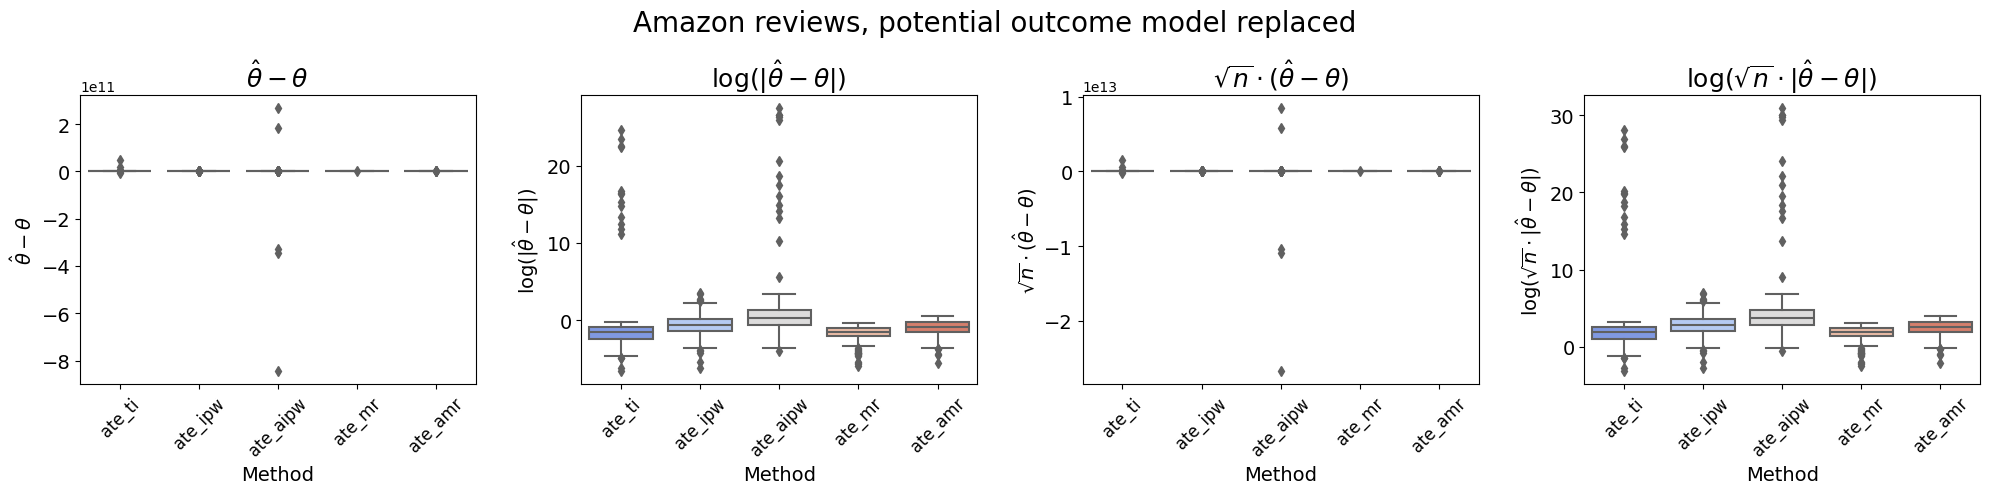

     Method     Mean_Diff      Std_Diff  Mean_Abs_Diff  Std_Abs_Diff  \
0    ate_ti  3.277982e+08  3.668389e+09   3.835832e+08  3.662976e+09   
1   ate_ipw  6.516720e-01  3.877123e+00   1.504535e+00  3.632236e+00   
2  ate_aipw -5.348609e+09  7.214221e+10   9.853170e+09  7.166604e+10   
3    ate_mr -2.235761e-01  1.874146e-01   2.438022e-01  1.602216e-01   
4   ate_amr  2.029854e-01  6.348918e-01   5.322248e-01  4.012822e-01   

           RMSE      Std_RMSE  
0  3.683005e+09  7.336778e+09  
1  3.931509e+00  7.754247e+00  
2  7.234021e+10  1.442844e+11  
3  2.917370e-01  3.748292e-01  
4  6.665513e-01  1.269784e+00  


In [20]:
# # Extract keys and true ATE
# ate_results = load('results/music/ate_extreme.joblib')
methods = [ 'ate_ti',  'ate_ipw', 'ate_aipw',  'ate_mr','ate_amr']

true_ate = np.array(ate_results['true_ate'])

# Calculate metrics
n = 1000
results = {}
for method in methods:
    estimates = np.array(ate_results[method])
    results[method] = {
        'estimation_bias': estimates - true_ate,
        'abs_bias': np.abs(estimates - true_ate),
        'sqrt_n_bias': np.sqrt(n) * (estimates - true_ate),
        'sqrt_n_abs_bias': np.sqrt(n) * np.abs(estimates - true_ate)
    }

# Prepare DataFrame for plotting
plot_data = []
for method, metrics in results.items():
    for metric_name, values in metrics.items():
        if "abs" in metric_name:  # Apply log only to absolute metrics
            values = values[values > 0]  # Avoid log(0) issues
        plot_data.append(pd.DataFrame({
            'Method': [method] * len(values),
            'Metric': [metric_name] * len(values),
            'Value': np.log(values) if "abs" in metric_name else values
        }))

plot_df = pd.concat(plot_data)

# Adjust method order
plot_df['Method'] = pd.Categorical(plot_df['Method'], categories=methods, ordered=True)

# Define custom titles for each metric
metric_titles = {
    'estimation_bias': r'$\hat{\theta}-\theta$',
    'abs_bias': r'$\log(|\hat{\theta}-\theta|)$',
    'sqrt_n_bias': r'$\sqrt{n} \cdot (\hat{\theta}-\theta)$',
    'sqrt_n_abs_bias': r'$\log(\sqrt{n} \cdot|\hat{\theta}-\theta|)$'
}

# Plot all metrics in a single row with four columns
unique_metrics = plot_df['Metric'].unique()
fig, axes = plt.subplots(1, len(unique_metrics), figsize=(20, 5), sharey=False)

for i, metric in enumerate(unique_metrics):
    metric_df = plot_df[plot_df['Metric'] == metric]
    ax = sns.boxplot(
        data=metric_df,
        x='Method',
        y='Value',
        palette='coolwarm',
        ax=axes[i]
    )
    # Annotate with means
    for j, box in enumerate(ax.artists):
        method = metric_df['Method'].unique()[j]
        metric_values = metric_df[metric_df['Method'] == method]['Value']
        mean_val = metric_values.mean()
        x_pos = box.get_x() + (box.get_width() / 2)
        ax.scatter(x_pos, mean_val, color='white', s=50, edgecolor='black')
    # Set titles and labels
    ax.set_title(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=18)
    ax.set_ylabel(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=14)
    ax.set_xlabel('Method', fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    ax.tick_params(axis='x', labelsize=12, rotation=45)
plt.suptitle('Amazon reviews, potential outcome model replaced', fontsize=20)
plt.tight_layout()
plt.show()

# Compute summary statistics
summary_stats = []


for method in methods:
    estimates = np.array(ate_results[method])
    diffs = estimates - true_ate
    abs_diffs = np.abs(diffs)
    mean_diff = np.mean(diffs)
    std_diff = np.std(diffs)
    mean_abs_diff = np.mean(abs_diffs)
    std_abs_diff = np.std(abs_diffs)
    rmse = np.sqrt(np.mean(diffs**2))
    std_rmse = np.std(diffs*2)  # Standard deviation for RMSE approximation

    summary_stats.append({
        'Method': method,
        'Mean_Diff': mean_diff,
        'Std_Diff': std_diff,
        'Mean_Abs_Diff': mean_abs_diff,
        'Std_Abs_Diff': std_abs_diff,
        'RMSE': rmse,
        'Std_RMSE': std_rmse
    })

summary_df = pd.DataFrame(summary_stats)
print(summary_df)


In [4]:
def text_trial_single_v2(n=2000, p=768, adjusted_ate=1, unadjusted_ate=2, embeddings=None, simulated_df=None,
                          cross_fit=True, n_folds=5, ps_model='torch_nn',or_model='torch_nn',w_model='kernel_ridge_regression', random_seed=42, stds_return=True, coverage_return=False):
    if p==768:
        ate = unadjusted_ate
    else:
        ate = adjusted_ate
    sampled_df = simulated_df.sample(n=n,replace=False,random_state=random_seed).reset_index()  
    

    # our method
    df = pd.merge(sampled_df, embeddings, on='text', how='inner')
    df.drop(columns=['index','Unnamed: 0','text'],inplace=True)
    df.rename(columns={'C': 'X769','T':'A', 'Y':'y'},inplace=True)
    if not stds_return:
        df_result,ates = single_text_trial(true_ate=ate, df_full=df, p=p, ps_model=ps_model, or_model=or_model, w_model=w_model, 
            random_seed=random_seed, cross_fit=cross_fit, n_folds=n_folds,stds_return=stds_return, coverage_return=coverage_return)
        Q0 = df_result['hat_mu0']
        Q1 = df_result['hat_mu1']
        A = df_result['A']
        Y = df_result['y']
        g = get_propensities(df_result['A'], Q0, Q1, 
                     model_type='GaussianProcessRegression', # choose the nonparametric model
                     kernel=None,    # kernel function for GPR
                     random_state=42) # random seed for GPR 
        att_ti, std_att_ti, _, _ = get_TI_estimator(g, Q0, Q1, A, Y, 
                  error=0.05)[0].values
        ate_ti, std_ate_ti, _, _ = ate_aiptw(np.array(Q0),np.array(Q1),A,Y,g,error_bound=0.05)
        all_ate = {'true_ate':ate,
                'ti_att':ti_att,
                'ti_ate':ti_ate,
                'ate_mr':ates['ate_mr'],
                'ate_ipw':ates['ate_ipw'],
                'ate_amr':ates['ate_amr'],
                'ate_aipw':ates['ate_aipw']}
        return all_ate
    else:
        df_result, ates, stds = single_text_trial(true_ate=ate, df_full=df, p=p, ps_model=ps_model, or_model=or_model, w_model=w_model, 
            random_seed=random_seed, cross_fit=cross_fit, n_folds=n_folds,stds_return=stds_return, coverage_return=coverage_return)
        Q0 = df_result['hat_mu0']
        Q1 = df_result['hat_mu1']
        A = df_result['A']
        Y = df_result['y']
        g = get_propensities(A, Q0, Q1, 
                     model_type='GaussianProcessRegression', # choose the nonparametric model
                     kernel=None,    # kernel function for GPR
                     random_state=42) # random seed for GPR 
        att_ti, std_att_ti, _, _ = get_TI_estimator(g, Q0, Q1, A, Y, 
                  error=0.05)[0].values
        ate_ti, std_ate_ti, _, _ = ate_aiptw(np.array(Q0),np.array(Q1),A,Y,g,error_bound=0.05)
        all_ate = {'true_ate':ate,
                    'att_ti':att_ti,
                    'ate_ti':ate_ti,
                    'ate_mr':ates['ate_mr'],
                    'ate_ipw':ates['ate_ipw'],
                    'ate_amr':ates['ate_amr'],
                    'ate_aipw':ates['ate_aipw']}
        
        all_std = {'std_att_ti': std_att_ti,
                    'std_ate_ti': std_ate_ti,
                    'std_mr': stds['ate_mr'],
                    'std_ipw': stds['ate_ipw'],
                    'std_amr': stds['ate_amr'],
                    'std_aipw': stds['ate_aipw']}
    

        return all_ate, all_std
def text_trial_v2(num_trials=200,n=2000, p=768, adjusted_ate=1, unadjusted_ate=3, embeddings=None, simulated_df=None,
                          cross_fit=True, n_folds=5, ps_model='torch_nn',or_model='torch_nn',w_model='kernel_ridge_regression', random_seed=42, stds_return=True, coverage_return=False):
    ate_results = {
    'true_ate': [],
    'att_ti': [],
    'ate_ti': [],
    'ate_mr': [],
    'ate_ipw': [],
    'ate_amr': [],
    'ate_aipw': []
    }
    std_results = {
        'std_att_ti': [],
        'std_ate_ti': [],
        'std_mr': [],
        'std_ipw': [],
        'std_amr': [],
        'std_aipw': []
    }

    
    for i in tqdm(range(num_trials)):
        if not stds_return:
            single_all_ate, = text_trial_single_v2(n=n, p=p, adjusted_ate=adjusted_ate, unadjusted_ate=unadjusted_ate, embeddings=embeddings, simulated_df=simulated_df,
                          cross_fit=cross_fit, n_folds=n_folds, ps_model=ps_model,or_model=or_model,w_model=w_model, random_seed=random_seed+i, stds_return=stds_return, coverage_return=coverage_return)
            for key, value in single_all_ate.items():
                ate_results[key].append(value)
            return ate_results
        else:
            single_all_ate, single_all_std = text_trial_single_v2(n=n, p=p, adjusted_ate=adjusted_ate, unadjusted_ate=unadjusted_ate, embeddings=embeddings, simulated_df=simulated_df,
                          cross_fit=cross_fit, n_folds=n_folds, ps_model=ps_model,or_model=or_model,w_model=w_model, random_seed=random_seed+i, stds_return=stds_return, coverage_return=coverage_return)
            for key, value in single_all_ate.items():
                ate_results[key].append(value)
            for key, value in single_all_std.items():
                std_results[key].append(value)

    return ate_results, std_results
    

In [9]:
ate_results, std_results = text_trial_v2(num_trials=50,n=1500, p=768, adjusted_ate=adjusted_ate, unadjusted_ate=unadjusted_ate, embeddings=embeddings, simulated_df=simulated_df,
                          cross_fit=True, n_folds=5, ps_model='torch_nn',or_model='lr',w_model='kernel_ridge_regression', random_seed=42, stds_return=True, coverage_return=False)
# Define the file path
ate_output_file = "results/music/ate_lr.joblib"
std_output_file = "results/music/std_lr.joblib"

# Ensure the directory exists
os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
os.makedirs(os.path.dirname(std_output_file), exist_ok=True)

# Save the results using joblib
dump(ate_results, ate_output_file)
print(f"Results saved to {ate_output_file}")
dump(std_results, std_output_file)
print(f"Results saved to {std_output_file}")

100%|██████████| 50/50 [19:30<00:00, 23.41s/it]

Results saved to results/music/ate_lr.joblib
Results saved to results/music/std_lr.joblib


In [10]:
ate_results

{'true_ate': [2.0814006160013028,
  2.0814006160013028,
  2.0814006160013028,
  2.0814006160013028,
  2.0814006160013028,
  2.0814006160013028,
  2.0814006160013028,
  2.0814006160013028,
  2.0814006160013028,
  2.0814006160013028,
  2.0814006160013028,
  2.0814006160013028,
  2.0814006160013028,
  2.0814006160013028,
  2.0814006160013028,
  2.0814006160013028,
  2.0814006160013028,
  2.0814006160013028,
  2.0814006160013028,
  2.0814006160013028,
  2.0814006160013028,
  2.0814006160013028,
  2.0814006160013028,
  2.0814006160013028,
  2.0814006160013028,
  2.0814006160013028,
  2.0814006160013028,
  2.0814006160013028,
  2.0814006160013028,
  2.0814006160013028,
  2.0814006160013028,
  2.0814006160013028,
  2.0814006160013028,
  2.0814006160013028,
  2.0814006160013028,
  2.0814006160013028,
  2.0814006160013028,
  2.0814006160013028,
  2.0814006160013028,
  2.0814006160013028,
  2.0814006160013028,
  2.0814006160013028,
  2.0814006160013028,
  2.0814006160013028,
  2.0814006160013028

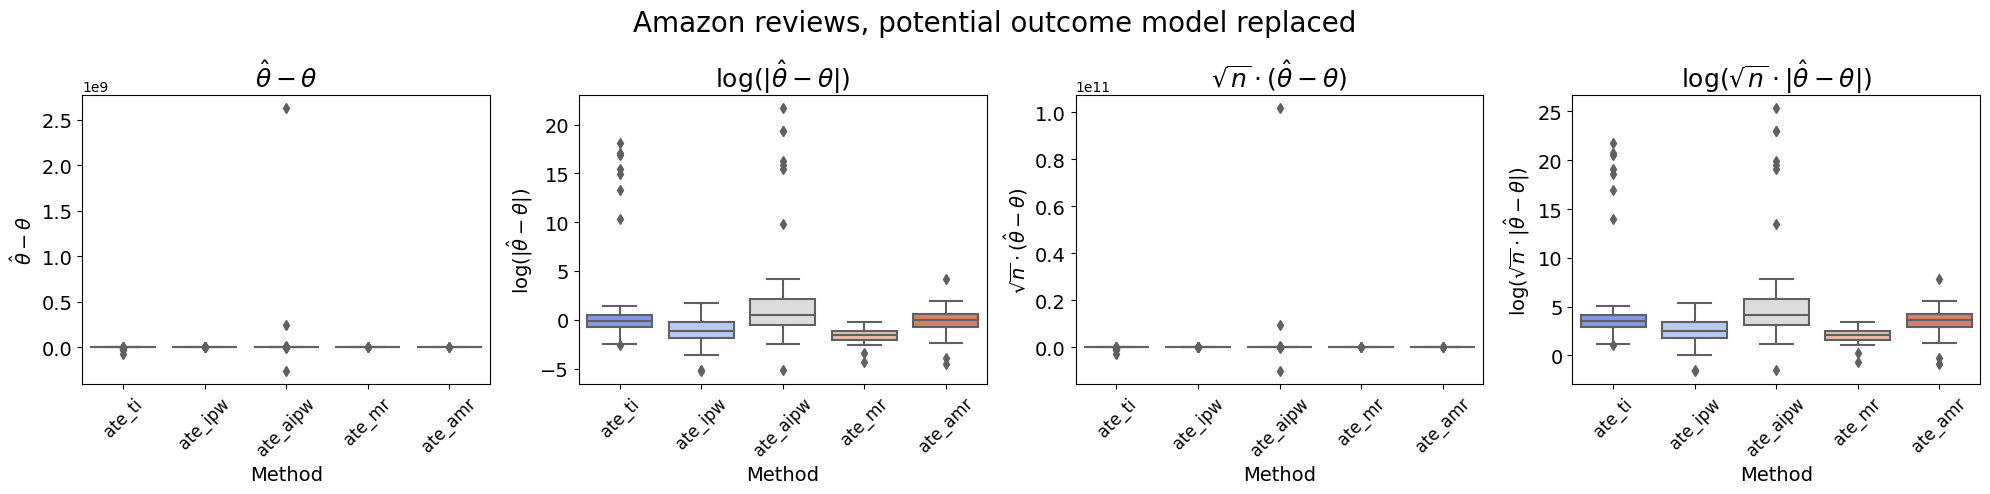

     Method     Mean_Diff      Std_Diff  Mean_Abs_Diff  Std_Abs_Diff  \
0    ate_ti -2.579814e+06  1.102721e+07   2.581016e+06  1.102693e+07   
1   ate_ipw  3.709170e-01  1.318574e+00   7.899358e-01  1.119026e+00   
2  ate_aipw  5.226317e+07  3.713215e+08   6.309777e+07  3.696347e+08   
3    ate_mr -2.187264e-01  1.765321e-01   2.372848e-01  1.506677e-01   
4   ate_amr  7.989302e-01  9.397268e+00   2.485927e+00  9.097643e+00   

           RMSE      Std_RMSE  
0  1.132497e+07  2.205443e+07  
1  1.369751e+00  2.637148e+00  
2  3.749815e+08  7.426431e+08  
3  2.810780e-01  3.530642e-01  
4  9.431168e+00  1.879454e+01  


In [11]:
# # Extract keys and true ATE
# ate_results = load('results/music/ate_extreme.joblib')
methods = [ 'ate_ti',  'ate_ipw', 'ate_aipw',  'ate_mr','ate_amr']

true_ate = np.array(ate_results['true_ate'])

# Calculate metrics
n = 1500
results = {}
for method in methods:
    estimates = np.array(ate_results[method])
    results[method] = {
        'estimation_bias': estimates - true_ate,
        'abs_bias': np.abs(estimates - true_ate),
        'sqrt_n_bias': np.sqrt(n) * (estimates - true_ate),
        'sqrt_n_abs_bias': np.sqrt(n) * np.abs(estimates - true_ate)
    }

# Prepare DataFrame for plotting
plot_data = []
for method, metrics in results.items():
    for metric_name, values in metrics.items():
        if "abs" in metric_name:  # Apply log only to absolute metrics
            values = values[values > 0]  # Avoid log(0) issues
        plot_data.append(pd.DataFrame({
            'Method': [method] * len(values),
            'Metric': [metric_name] * len(values),
            'Value': np.log(values) if "abs" in metric_name else values
        }))

plot_df = pd.concat(plot_data)

# Adjust method order
plot_df['Method'] = pd.Categorical(plot_df['Method'], categories=methods, ordered=True)

# Define custom titles for each metric
metric_titles = {
    'estimation_bias': r'$\hat{\theta}-\theta$',
    'abs_bias': r'$\log(|\hat{\theta}-\theta|)$',
    'sqrt_n_bias': r'$\sqrt{n} \cdot (\hat{\theta}-\theta)$',
    'sqrt_n_abs_bias': r'$\log(\sqrt{n} \cdot|\hat{\theta}-\theta|)$'
}

# Plot all metrics in a single row with four columns
unique_metrics = plot_df['Metric'].unique()
fig, axes = plt.subplots(1, len(unique_metrics), figsize=(20, 5), sharey=False)

for i, metric in enumerate(unique_metrics):
    metric_df = plot_df[plot_df['Metric'] == metric]
    ax = sns.boxplot(
        data=metric_df,
        x='Method',
        y='Value',
        palette='coolwarm',
        ax=axes[i]
    )
    # Annotate with means
    for j, box in enumerate(ax.artists):
        method = metric_df['Method'].unique()[j]
        metric_values = metric_df[metric_df['Method'] == method]['Value']
        mean_val = metric_values.mean()
        x_pos = box.get_x() + (box.get_width() / 2)
        ax.scatter(x_pos, mean_val, color='white', s=50, edgecolor='black')
    # Set titles and labels
    ax.set_title(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=18)
    ax.set_ylabel(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=14)
    ax.set_xlabel('Method', fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    ax.tick_params(axis='x', labelsize=12, rotation=45)
plt.suptitle('Amazon reviews, potential outcome model replaced', fontsize=20)
plt.tight_layout()
plt.show()

# Compute summary statistics
summary_stats = []


for method in methods:
    estimates = np.array(ate_results[method])
    diffs = estimates - true_ate
    abs_diffs = np.abs(diffs)
    mean_diff = np.mean(diffs)
    std_diff = np.std(diffs)
    mean_abs_diff = np.mean(abs_diffs)
    std_abs_diff = np.std(abs_diffs)
    rmse = np.sqrt(np.mean(diffs**2))
    std_rmse = np.std(diffs*2)  # Standard deviation for RMSE approximation

    summary_stats.append({
        'Method': method,
        'Mean_Diff': mean_diff,
        'Std_Diff': std_diff,
        'Mean_Abs_Diff': mean_abs_diff,
        'Std_Abs_Diff': std_abs_diff,
        'RMSE': rmse,
        'Std_RMSE': std_rmse
    })

summary_df = pd.DataFrame(summary_stats)
print(summary_df)


In [9]:

ate_results, std_results = text_trial_v2(num_trials=50,n=1000, p=768, adjusted_ate=adjusted_ate, unadjusted_ate=unadjusted_ate, embeddings=embeddings, simulated_df=simulated_df,
                          cross_fit=True, n_folds=5, ps_model='torch_nn',or_model='lr',w_model='kernel_ridge_regression', random_seed=42, stds_return=True, coverage_return=False)
# Define the file path
ate_output_file = "results/music/ate_rf.joblib"
std_output_file = "results/music/std_rf.joblib"

# Ensure the directory exists
os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
os.makedirs(os.path.dirname(std_output_file), exist_ok=True)

# Save the results using joblib
dump(ate_results, ate_output_file)
print(f"Results saved to {ate_output_file}")
dump(std_results, std_output_file)
print(f"Results saved to {std_output_file}")

100%|██████████| 50/50 [2:02:01<00:00, 146.42s/it]  

Results saved to results/music/ate_rf.joblib
Results saved to results/music/std_rf.joblib


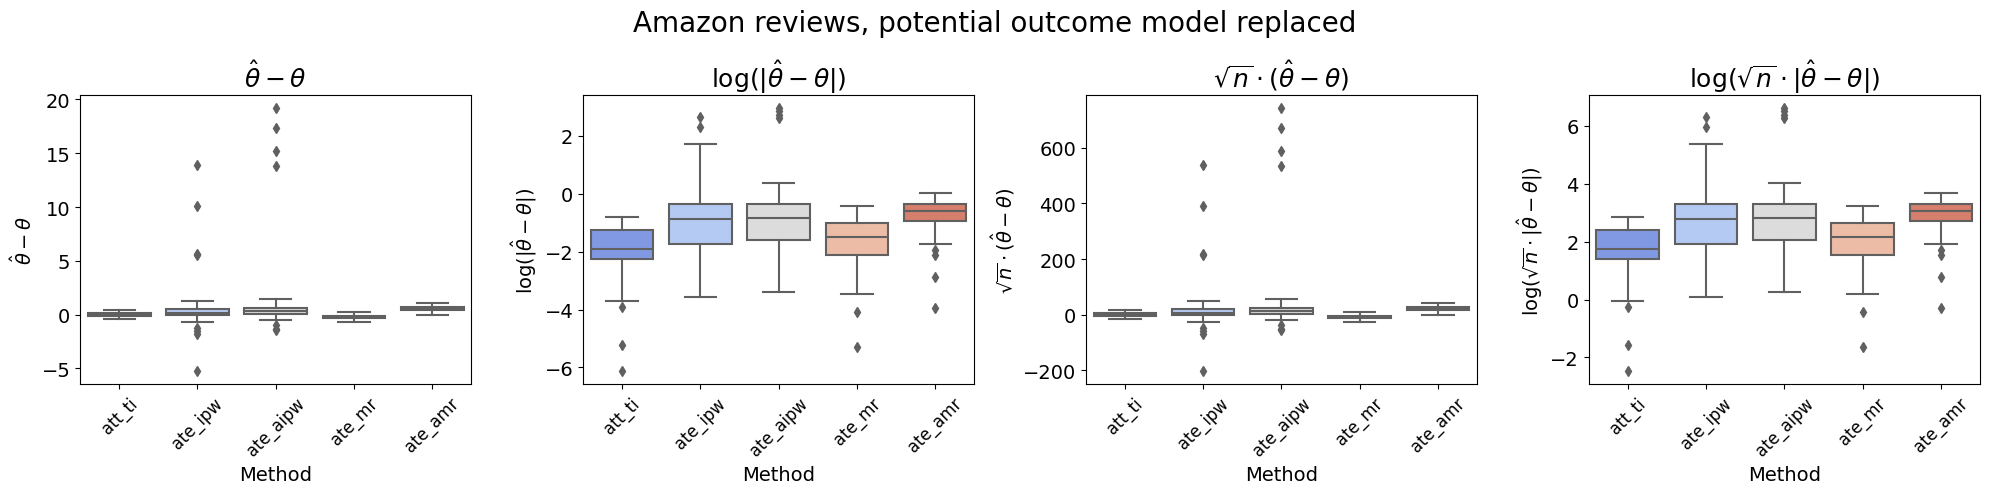

     Method  Mean_Diff  Std_Diff  Mean_Abs_Diff  Std_Abs_Diff      RMSE  \
0    att_ti  -0.017011  0.224204       0.189442      0.121114  0.224849   
1   ate_ipw   0.698839  2.749704       1.226926      2.558105  2.837120   
2  ate_aipw   1.505201  4.460666       1.738989      4.374825  4.707778   
3    ate_mr  -0.234261  0.198026       0.254761      0.170848  0.306745   
4   ate_amr   0.536011  0.242756       0.536774      0.241064  0.588420   

   Std_RMSE  
0  0.448408  
1  5.499408  
2  8.921332  
3  0.396052  
4  0.485511  


In [12]:
# # Extract keys and true ATE
# ate_results = load('results/music/ate_extreme.joblib')
methods = [ 'att_ti',  'ate_ipw', 'ate_aipw',  'ate_mr','ate_amr']

true_ate = np.array(ate_results['true_ate'])

# Calculate metrics
n = 1500
results = {}
for method in methods:
    estimates = np.array(ate_results[method])
    results[method] = {
        'estimation_bias': estimates - true_ate,
        'abs_bias': np.abs(estimates - true_ate),
        'sqrt_n_bias': np.sqrt(n) * (estimates - true_ate),
        'sqrt_n_abs_bias': np.sqrt(n) * np.abs(estimates - true_ate)
    }

# Prepare DataFrame for plotting
plot_data = []
for method, metrics in results.items():
    for metric_name, values in metrics.items():
        if "abs" in metric_name:  # Apply log only to absolute metrics
            values = values[values > 0]  # Avoid log(0) issues
        plot_data.append(pd.DataFrame({
            'Method': [method] * len(values),
            'Metric': [metric_name] * len(values),
            'Value': np.log(values) if "abs" in metric_name else values
        }))

plot_df = pd.concat(plot_data)

# Adjust method order
plot_df['Method'] = pd.Categorical(plot_df['Method'], categories=methods, ordered=True)

# Define custom titles for each metric
metric_titles = {
    'estimation_bias': r'$\hat{\theta}-\theta$',
    'abs_bias': r'$\log(|\hat{\theta}-\theta|)$',
    'sqrt_n_bias': r'$\sqrt{n} \cdot (\hat{\theta}-\theta)$',
    'sqrt_n_abs_bias': r'$\log(\sqrt{n} \cdot|\hat{\theta}-\theta|)$'
}

# Plot all metrics in a single row with four columns
unique_metrics = plot_df['Metric'].unique()
fig, axes = plt.subplots(1, len(unique_metrics), figsize=(20, 5), sharey=False)

for i, metric in enumerate(unique_metrics):
    metric_df = plot_df[plot_df['Metric'] == metric]
    ax = sns.boxplot(
        data=metric_df,
        x='Method',
        y='Value',
        palette='coolwarm',
        ax=axes[i]
    )
    # Annotate with means
    for j, box in enumerate(ax.artists):
        method = metric_df['Method'].unique()[j]
        metric_values = metric_df[metric_df['Method'] == method]['Value']
        mean_val = metric_values.mean()
        x_pos = box.get_x() + (box.get_width() / 2)
        ax.scatter(x_pos, mean_val, color='white', s=50, edgecolor='black')
    # Set titles and labels
    ax.set_title(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=18)
    ax.set_ylabel(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=14)
    ax.set_xlabel('Method', fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    ax.tick_params(axis='x', labelsize=12, rotation=45)
plt.suptitle('Amazon reviews, potential outcome model replaced', fontsize=20)
plt.tight_layout()
plt.show()

# Compute summary statistics
summary_stats = []


for method in methods:
    estimates = np.array(ate_results[method])
    diffs = estimates - true_ate
    abs_diffs = np.abs(diffs)
    mean_diff = np.mean(diffs)
    std_diff = np.std(diffs)
    mean_abs_diff = np.mean(abs_diffs)
    std_abs_diff = np.std(abs_diffs)
    rmse = np.sqrt(np.mean(diffs**2))
    std_rmse = np.std(diffs*2)  # Standard deviation for RMSE approximation

    summary_stats.append({
        'Method': method,
        'Mean_Diff': mean_diff,
        'Std_Diff': std_diff,
        'Mean_Abs_Diff': mean_abs_diff,
        'Std_Abs_Diff': std_abs_diff,
        'RMSE': rmse,
        'Std_RMSE': std_rmse
    })

summary_df = pd.DataFrame(summary_stats)
print(summary_df)


# Knn as weighting regression

In [4]:
raw_df = pd.read_csv('../data/music/music.csv')
simulated_df, offset =run_simulation(raw_df, propensities=[0.9, 0.3], 
                            beta_t=1.0,  # 1.0, 0.0
                            beta_c=50.0, # 50.0, 100.0
                            gamma=1,    # 1.0, 4.0
                            cts=True)    
simulated_df = simulated_df.drop_duplicates(subset='text')
adjusted_ate = ATE_adjusted(simulated_df['C'], simulated_df['T'], simulated_df['Y'])
unadjusted_ate = ATE_unadjusted(simulated_df['T'], simulated_df['Y'])
print('adjusted ATE: ', adjusted_ate)
print('unadjusted ATE: ', unadjusted_ate)


Offset: 0.5251528593693802
[0.1, 0.9]
[0.7000575705238917, 0.2999424294761082]
adjusted ATE:  1.0109675356801975
unadjusted ATE:  17.846662260891346


In [5]:
def text_trial_single_v2(n=2000, p=768, adjusted_ate=1, unadjusted_ate=2, embeddings=None, simulated_df=None,
                          cross_fit=True, n_folds=5, ps_model='torch_nn',or_model='torch_nn',w_model='kernel_ridge_regression', random_seed=42, stds_return=True, coverage_return=False):
    if p==768:
        ate = unadjusted_ate
    else:
        ate = adjusted_ate
    sampled_df = simulated_df.sample(n=n,replace=False,random_state=random_seed).reset_index()  
    

    # our method
    df = pd.merge(sampled_df, embeddings, on='text', how='inner')
    df.drop(columns=['index','Unnamed: 0','text'],inplace=True)
    df.rename(columns={'C': 'X769','T':'A', 'Y':'y'},inplace=True)
    if not stds_return:
        df_result,ates = single_text_trial(true_ate=ate, df_full=df, p=p, ps_model=ps_model, or_model=or_model, w_model=w_model, 
            random_seed=random_seed, cross_fit=cross_fit, n_folds=n_folds,stds_return=stds_return, coverage_return=coverage_return)
        Q0 = df_result['hat_mu0']
        Q1 = df_result['hat_mu1']
        A = df_result['A']
        Y = df_result['y']
        g = get_propensities(df_result['A'], Q0, Q1, 
                     model_type='KNearestNeighbors', # choose the nonparametric model
                     kernel=None,    # kernel function for GPR
                     random_state=42) # random seed for GPR 
        att_ti, std_att_ti, _, _ = get_TI_estimator(g, Q0, Q1, A, Y, 
                  error=0.05)[0].values
        ate_ti, std_ate_ti, _, _ = ate_aiptw(np.array(Q0),np.array(Q1),A,Y,g,error_bound=0.05)
        all_ate = {'true_ate':ate,
                'ti_att':ti_att,
                'ti_ate':ti_ate,
                'ate_mr':ates['ate_mr'],
                'ate_ipw':ates['ate_ipw'],
                'ate_amr':ates['ate_amr'],
                'ate_aipw':ates['ate_aipw']}
        return all_ate
    else:
        df_result, ates, stds = single_text_trial(true_ate=ate, df_full=df, p=p, ps_model=ps_model, or_model=or_model, w_model=w_model, 
            random_seed=random_seed, cross_fit=cross_fit, n_folds=n_folds,stds_return=stds_return, coverage_return=coverage_return)
        Q0 = df_result['hat_mu0']
        Q1 = df_result['hat_mu1']
        A = df_result['A']
        Y = df_result['y']
        g = get_propensities(A, Q0, Q1, 
                     model_type='KNearestNeighbors', # choose the nonparametric model
                     kernel=None,    # kernel function for GPR
                     random_state=42) # random seed for GPR 
        att_ti, std_att_ti, _, _ = get_TI_estimator(g, Q0, Q1, A, Y, 
                  error=0.05)[0].values
        ate_ti, std_ate_ti, _, _ = ate_aiptw(np.array(Q0),np.array(Q1),A,Y,g,error_bound=0.05)
        all_ate = {'true_ate':ate,
                    'att_ti':att_ti,
                    'ate_ti':ate_ti,
                    'ate_mr':ates['ate_mr'],
                    'ate_ipw':ates['ate_ipw'],
                    'ate_amr':ates['ate_amr'],
                    'ate_aipw':ates['ate_aipw']}
        
        all_std = {'std_att_ti': std_att_ti,
                    'std_ate_ti': std_ate_ti,
                    'std_mr': stds['ate_mr'],
                    'std_ipw': stds['ate_ipw'],
                    'std_amr': stds['ate_amr'],
                    'std_aipw': stds['ate_aipw']}
    

        return all_ate, all_std
def text_trial_v2(num_trials=200,n=2000, p=768, adjusted_ate=1, unadjusted_ate=3, embeddings=None, simulated_df=None,
                          cross_fit=True, n_folds=5, ps_model='torch_nn',or_model='torch_nn',w_model='kernel_ridge_regression', random_seed=42, stds_return=True, coverage_return=False):
    ate_results = {
    'true_ate': [],
    'att_ti': [],
    'ate_ti': [],
    'ate_mr': [],
    'ate_ipw': [],
    'ate_amr': [],
    'ate_aipw': []
    }
    std_results = {
        'std_att_ti': [],
        'std_ate_ti': [],
        'std_mr': [],
        'std_ipw': [],
        'std_amr': [],
        'std_aipw': []
    }

    
    for i in tqdm(range(num_trials)):
        if not stds_return:
            single_all_ate, = text_trial_single_v2(n=n, p=p, adjusted_ate=adjusted_ate, unadjusted_ate=unadjusted_ate, embeddings=embeddings, simulated_df=simulated_df,
                          cross_fit=cross_fit, n_folds=n_folds, ps_model=ps_model,or_model=or_model,w_model=w_model, random_seed=random_seed+i, stds_return=stds_return, coverage_return=coverage_return)
            for key, value in single_all_ate.items():
                ate_results[key].append(value)
            return ate_results
        else:
            single_all_ate, single_all_std = text_trial_single_v2(n=n, p=p, adjusted_ate=adjusted_ate, unadjusted_ate=unadjusted_ate, embeddings=embeddings, simulated_df=simulated_df,
                          cross_fit=cross_fit, n_folds=n_folds, ps_model=ps_model,or_model=or_model,w_model=w_model, random_seed=random_seed+i, stds_return=stds_return, coverage_return=coverage_return)
            for key, value in single_all_ate.items():
                ate_results[key].append(value)
            for key, value in single_all_std.items():
                std_results[key].append(value)

    return ate_results, std_results
    

In [6]:

ate_results, std_results = text_trial_v2(num_trials=50,n=1000, p=768, adjusted_ate=adjusted_ate, unadjusted_ate=unadjusted_ate, embeddings=embeddings, simulated_df=simulated_df,
                          cross_fit=True, n_folds=5, ps_model='torch_nn',or_model='lr',w_model='kernel_ridge_regression', random_seed=42, stds_return=True, coverage_return=False)
# # Define the file path
# ate_output_file = "results/music/ate_rf.joblib"
# std_output_file = "results/music/std_rf.joblib"

# # Ensure the directory exists
# os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
# os.makedirs(os.path.dirname(std_output_file), exist_ok=True)

# # Save the results using joblib
# dump(ate_results, ate_output_file)
# print(f"Results saved to {ate_output_file}")
# dump(std_results, std_output_file)
# print(f"Results saved to {std_output_file}")

100%|██████████| 50/50 [12:09<00:00, 14.59s/it]


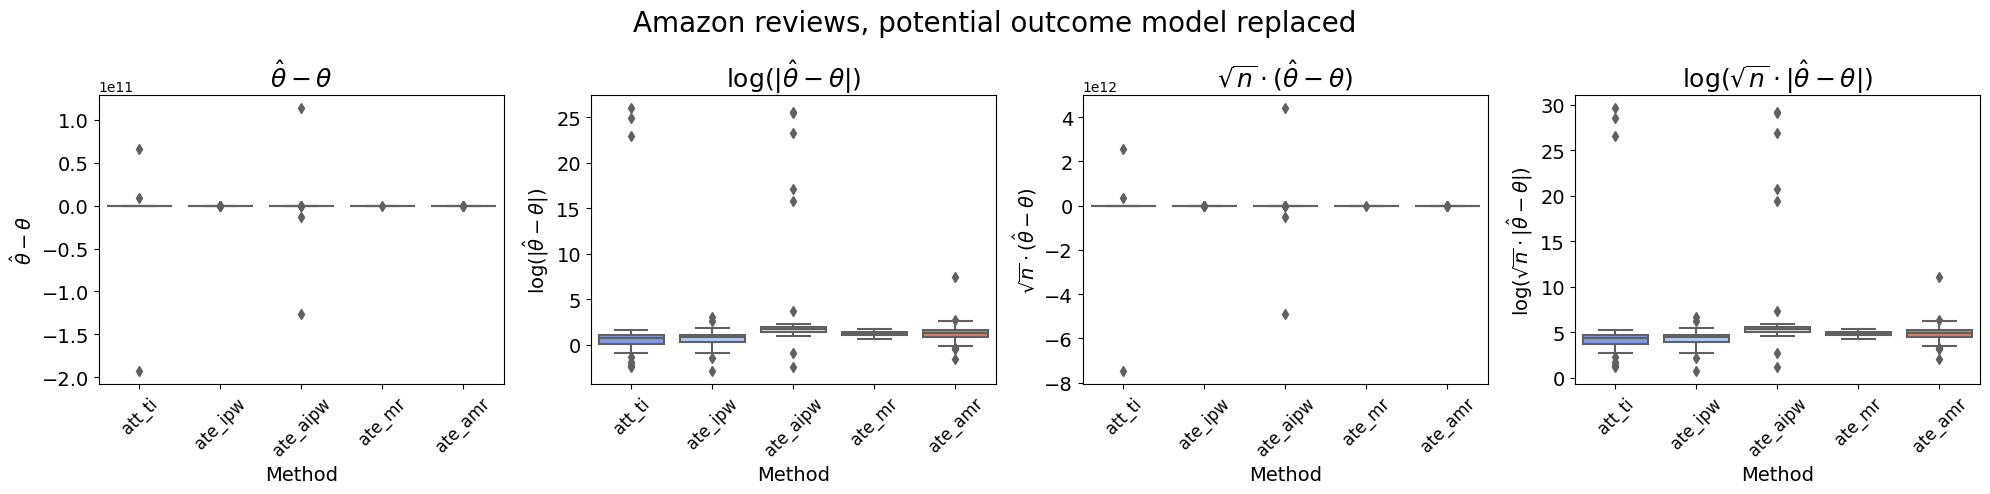

     Method     Mean_Diff      Std_Diff  Mean_Abs_Diff  Std_Abs_Diff  \
0    att_ti -2.348017e+09  2.882284e+10   5.376385e+09  2.841415e+10   
1   ate_ipw -2.544233e+00  3.448202e+00   2.807168e+00  3.237751e+00   
2  ate_aipw -5.007985e+08  2.406332e+10   5.052037e+09  2.353234e+10   
3    ate_mr -3.291017e+00  8.539127e-01   3.291017e+00  8.539127e-01   
4   ate_amr  2.848396e+01  2.290688e+02   3.679678e+01  2.278812e+02   

           RMSE      Std_RMSE  
0  2.891832e+10  5.764568e+10  
1  4.285233e+00  6.896405e+00  
2  2.406853e+10  4.812664e+10  
3  3.399994e+00  1.707825e+00  
4  2.308330e+02  4.581377e+02  


In [7]:
# # Extract keys and true ATE
# ate_results = load('results/music/ate_extreme.joblib')
methods = [ 'att_ti',  'ate_ipw', 'ate_aipw',  'ate_mr','ate_amr']

true_ate = np.array(ate_results['true_ate'])

# Calculate metrics
n = 1500
results = {}
for method in methods:
    estimates = np.array(ate_results[method])
    results[method] = {
        'estimation_bias': estimates - true_ate,
        'abs_bias': np.abs(estimates - true_ate),
        'sqrt_n_bias': np.sqrt(n) * (estimates - true_ate),
        'sqrt_n_abs_bias': np.sqrt(n) * np.abs(estimates - true_ate)
    }

# Prepare DataFrame for plotting
plot_data = []
for method, metrics in results.items():
    for metric_name, values in metrics.items():
        if "abs" in metric_name:  # Apply log only to absolute metrics
            values = values[values > 0]  # Avoid log(0) issues
        plot_data.append(pd.DataFrame({
            'Method': [method] * len(values),
            'Metric': [metric_name] * len(values),
            'Value': np.log(values) if "abs" in metric_name else values
        }))

plot_df = pd.concat(plot_data)

# Adjust method order
plot_df['Method'] = pd.Categorical(plot_df['Method'], categories=methods, ordered=True)

# Define custom titles for each metric
metric_titles = {
    'estimation_bias': r'$\hat{\theta}-\theta$',
    'abs_bias': r'$\log(|\hat{\theta}-\theta|)$',
    'sqrt_n_bias': r'$\sqrt{n} \cdot (\hat{\theta}-\theta)$',
    'sqrt_n_abs_bias': r'$\log(\sqrt{n} \cdot|\hat{\theta}-\theta|)$'
}

# Plot all metrics in a single row with four columns
unique_metrics = plot_df['Metric'].unique()
fig, axes = plt.subplots(1, len(unique_metrics), figsize=(20, 5), sharey=False)

for i, metric in enumerate(unique_metrics):
    metric_df = plot_df[plot_df['Metric'] == metric]
    ax = sns.boxplot(
        data=metric_df,
        x='Method',
        y='Value',
        palette='coolwarm',
        ax=axes[i]
    )
    # Annotate with means
    for j, box in enumerate(ax.artists):
        method = metric_df['Method'].unique()[j]
        metric_values = metric_df[metric_df['Method'] == method]['Value']
        mean_val = metric_values.mean()
        x_pos = box.get_x() + (box.get_width() / 2)
        ax.scatter(x_pos, mean_val, color='white', s=50, edgecolor='black')
    # Set titles and labels
    ax.set_title(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=18)
    ax.set_ylabel(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=14)
    ax.set_xlabel('Method', fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    ax.tick_params(axis='x', labelsize=12, rotation=45)
plt.suptitle('Amazon reviews, potential outcome model replaced', fontsize=20)
plt.tight_layout()
plt.show()

# Compute summary statistics
summary_stats = []


for method in methods:
    estimates = np.array(ate_results[method])
    diffs = estimates - true_ate
    abs_diffs = np.abs(diffs)
    mean_diff = np.mean(diffs)
    std_diff = np.std(diffs)
    mean_abs_diff = np.mean(abs_diffs)
    std_abs_diff = np.std(abs_diffs)
    rmse = np.sqrt(np.mean(diffs**2))
    std_rmse = np.std(diffs*2)  # Standard deviation for RMSE approximation

    summary_stats.append({
        'Method': method,
        'Mean_Diff': mean_diff,
        'Std_Diff': std_diff,
        'Mean_Abs_Diff': mean_abs_diff,
        'Std_Abs_Diff': std_abs_diff,
        'RMSE': rmse,
        'Std_RMSE': std_rmse
    })

summary_df = pd.DataFrame(summary_stats)
print(summary_df)


# No difference in propensity sccore between C=1 and C=0

In [3]:
def text_trial_single_v2(n=2000, p=768, adjusted_ate=1, unadjusted_ate=2, embeddings=None, simulated_df=None,
                          cross_fit=True, n_folds=5, ps_model='torch_nn',or_model='torch_nn',w_model='kernel_ridge_regression', random_seed=42, stds_return=True, coverage_return=False):
    if p==768:
        ate = unadjusted_ate
    else:
        ate = adjusted_ate
    sampled_df = simulated_df.sample(n=n,replace=False,random_state=random_seed).reset_index()  
    

    # our method
    df = pd.merge(sampled_df, embeddings, on='text', how='inner')
    df.drop(columns=['index','Unnamed: 0','text'],inplace=True)
    df.rename(columns={'C': 'X769','T':'A', 'Y':'y'},inplace=True)
    if not stds_return:
        df_result,ates = single_text_trial(true_ate=ate, df_full=df, p=p, ps_model=ps_model, or_model=or_model, w_model=w_model, 
            random_seed=random_seed, cross_fit=cross_fit, n_folds=n_folds,stds_return=stds_return, coverage_return=coverage_return)
        Q0 = df_result['hat_mu0']
        Q1 = df_result['hat_mu1']
        A = df_result['A']
        Y = df_result['y']
        g = get_propensities(df_result['A'], Q0, Q1, 
                     model_type='GaussianProcessRegression', # choose the nonparametric model
                     kernel=None,    # kernel function for GPR
                     random_state=42) # random seed for GPR 
        att_ti, std_att_ti, _, _ = get_TI_estimator(g, Q0, Q1, A, Y, 
                  error=0.05)[0].values
        ate_ti, std_ate_ti, _, _ = ate_aiptw(np.array(Q0),np.array(Q1),A,Y,g,error_bound=0.05)
        all_ate = {'true_ate':ate,
                'ti_att':ti_att,
                'ti_ate':ti_ate,
                'ate_mr':ates['ate_mr'],
                'ate_ipw':ates['ate_ipw'],
                'ate_amr':ates['ate_amr'],
                'ate_aipw':ates['ate_aipw']}
        return all_ate
    else:
        df_result, ates, stds = single_text_trial(true_ate=ate, df_full=df, p=p, ps_model=ps_model, or_model=or_model, w_model=w_model, 
            random_seed=random_seed, cross_fit=cross_fit, n_folds=n_folds,stds_return=stds_return, coverage_return=coverage_return)
        Q0 = df_result['hat_mu0']
        Q1 = df_result['hat_mu1']
        A = df_result['A']
        Y = df_result['y']
        g = get_propensities(A, Q0, Q1, 
                     model_type='GaussianProcessRegression', # choose the nonparametric model
                     kernel=None,    # kernel function for GPR
                     random_state=42) # random seed for GPR 
        att_ti, std_att_ti, _, _ = get_TI_estimator(g, Q0, Q1, A, Y, 
                  error=0.05)[0].values
        ate_ti, std_ate_ti, _, _ = ate_aiptw(np.array(Q0),np.array(Q1),A,Y,g,error_bound=0.05)
        all_ate = {'true_ate':ate,
                    'att_ti':att_ti,
                    'ate_ti':ate_ti,
                    'ate_mr':ates['ate_mr'],
                    'ate_ipw':ates['ate_ipw'],
                    'ate_amr':ates['ate_amr'],
                    'ate_aipw':ates['ate_aipw']}
        
        all_std = {'std_att_ti': std_att_ti,
                    'std_ate_ti': std_ate_ti,
                    'std_mr': stds['ate_mr'],
                    'std_ipw': stds['ate_ipw'],
                    'std_amr': stds['ate_amr'],
                    'std_aipw': stds['ate_aipw']}
    

        return all_ate, all_std
def text_trial_v2(num_trials=200,n=2000, p=768, adjusted_ate=1, unadjusted_ate=3, embeddings=None, simulated_df=None,
                          cross_fit=True, n_folds=5, ps_model='torch_nn',or_model='torch_nn',w_model='kernel_ridge_regression', random_seed=42, stds_return=True, coverage_return=False):
    ate_results = {
    'true_ate': [],
    'att_ti': [],
    'ate_ti': [],
    'ate_mr': [],
    'ate_ipw': [],
    'ate_amr': [],
    'ate_aipw': []
    }
    std_results = {
        'std_att_ti': [],
        'std_ate_ti': [],
        'std_mr': [],
        'std_ipw': [],
        'std_amr': [],
        'std_aipw': []
    }

    
    for i in tqdm(range(num_trials)):
        if not stds_return:
            single_all_ate, = text_trial_single_v2(n=n, p=p, adjusted_ate=adjusted_ate, unadjusted_ate=unadjusted_ate, embeddings=embeddings, simulated_df=simulated_df,
                          cross_fit=cross_fit, n_folds=n_folds, ps_model=ps_model,or_model=or_model,w_model=w_model, random_seed=random_seed+i, stds_return=stds_return, coverage_return=coverage_return)
            for key, value in single_all_ate.items():
                ate_results[key].append(value)
            return ate_results
        else:
            single_all_ate, single_all_std = text_trial_single_v2(n=n, p=p, adjusted_ate=adjusted_ate, unadjusted_ate=unadjusted_ate, embeddings=embeddings, simulated_df=simulated_df,
                          cross_fit=cross_fit, n_folds=n_folds, ps_model=ps_model,or_model=or_model,w_model=w_model, random_seed=random_seed+i, stds_return=stds_return, coverage_return=coverage_return)
            for key, value in single_all_ate.items():
                ate_results[key].append(value)
            for key, value in single_all_std.items():
                std_results[key].append(value)

    return ate_results, std_results
    

In [50]:
raw_df = pd.read_csv('../data/music/music.csv')
simulated_df, offset = run_simulation(
    raw_df,
    propensities=[0.3, 0.9],
    beta_t=2.0,
    beta_c=20,
    gamma=2,
    cts=True,
    nonlinear=True  # <--- This triggers the more complicated outcome
)
simulated_df = simulated_df.drop_duplicates(subset='text')
adjusted_ate = ATE_adjusted(simulated_df['C'], simulated_df['T'], simulated_df['Y'])
unadjusted_ate = ATE_unadjusted(simulated_df['T'], simulated_df['Y'])
print('adjusted ATE: ', adjusted_ate)
print('unadjusted ATE: ', unadjusted_ate)


[0.7002237136465325, 0.29977628635346754]
[0.1, 0.9]
adjusted ATE:  3.172155244238862
unadjusted ATE:  0.23967805112280338


In [54]:
#simulated_df['propen']=[0.9]*simulated_df.shape[0]
ate_results, std_results = text_trial_v2(num_trials=50,n=1000, p=768, adjusted_ate=adjusted_ate, unadjusted_ate=unadjusted_ate, embeddings=embeddings, simulated_df=simulated_df,
                          cross_fit=True, n_folds=3, ps_model='torch_nn',or_model='torch_nn',w_model='kernel_ridge_regression', random_seed=42, stds_return=True, coverage_return=False)
# # Define the file path
ate_output_file = "results/music/ate_nn.joblib"
std_output_file = "results/music/std_nn.joblib"

# Ensure the directory exists
os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
os.makedirs(os.path.dirname(std_output_file), exist_ok=True)

# Save the results using joblib
dump(ate_results, ate_output_file)
print(f"Results saved to {ate_output_file}")
dump(std_results, std_output_file)
print(f"Results saved to {std_output_file}")

  0%|          | 0/50 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/_gpc.py:456: RuntimeWarning: overflow encountered in exp
  - np.log1p(np.exp(-(self.y_train_ * 2 - 1) * f)).sum()
/opt/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/_gpc.py:462: RuntimeWarning: invalid value encountered in scalar subtract
  if lml - log_marginal_likelihood < 1e-10:
  6%|▌         | 3/50 [02:28<35:22, 45.16s/it]  /opt/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/_gpc.py:456: RuntimeWarning: overflow encountered in exp
  - np.log1p(np.exp(-(self.y_train_ * 2 - 1) * f)).sum()
/opt/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/_gpc.py:462: RuntimeWarning: invalid value encountered in scalar subtract
  if lml - log_marginal_likelihood < 1e-10:
 20%|██        | 10/50 [06:53<21:08, 31.71s/it]/opt/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/_gpc.py:456: RuntimeWarning: overflow encountered in exp
 

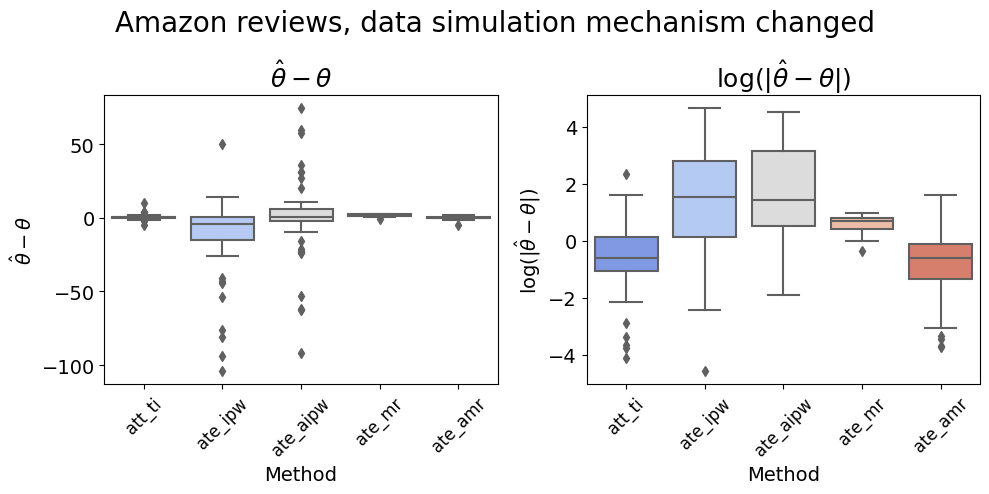

     Method  Mean_Diff   Std_Diff  Mean_Abs_Diff  Std_Abs_Diff       RMSE  \
0    att_ti   0.360121   1.890575       1.053205      1.610814   1.924568   
1   ate_ipw -13.526019  27.303689      16.717664     25.474779  30.470390   
2  ate_aipw  -0.147522  27.798923      16.303798     22.516396  27.799315   
3    ate_mr   1.820988   0.622000       1.866828      0.466729   1.924287   
4   ate_amr   0.003002   1.056656       0.718367      0.774907   1.056660   

    Std_RMSE  
0   3.781150  
1  54.607379  
2  55.597847  
3   1.244000  
4   2.113312  


In [3]:
# # Extract keys and true ATE
ate_results = load('results/music/ate_nn.joblib')
methods = [ 'att_ti',  'ate_ipw', 'ate_aipw',  'ate_mr','ate_amr']

true_ate = np.array(ate_results['true_ate'])

# Calculate metrics
n = 1000
results = {}
for method in methods:
    estimates = np.array(ate_results[method])
    results[method] = {
        'estimation_bias': estimates - true_ate,
        'abs_bias': np.abs(estimates - true_ate),
        # 'sqrt_n_bias': np.sqrt(n) * (estimates - true_ate),
        # 'sqrt_n_abs_bias': np.sqrt(n) * np.abs(estimates - true_ate)
    }

# Prepare DataFrame for plotting
plot_data = []
for method, metrics in results.items():
    for metric_name, values in metrics.items():
        if "abs" in metric_name:  # Apply log only to absolute metrics
            values = values[values > 0]  # Avoid log(0) issues
        plot_data.append(pd.DataFrame({
            'Method': [method] * len(values),
            'Metric': [metric_name] * len(values),
            'Value': np.log(values) if "abs" in metric_name else values
        }))

plot_df = pd.concat(plot_data)

# Adjust method order
plot_df['Method'] = pd.Categorical(plot_df['Method'], categories=methods, ordered=True)

# Define custom titles for each metric
metric_titles = {
    'estimation_bias': r'$\hat{\theta}-\theta$',
    'abs_bias': r'$\log(|\hat{\theta}-\theta|)$',
    # 'sqrt_n_bias': r'$\sqrt{n} \cdot (\hat{\theta}-\theta)$',
    # 'sqrt_n_abs_bias': r'$\log(\sqrt{n} \cdot|\hat{\theta}-\theta|)$'
}

# Plot all metrics in a single row with four columns
unique_metrics = plot_df['Metric'].unique()
fig, axes = plt.subplots(1, len(unique_metrics), figsize=(10, 5), sharey=False)

for i, metric in enumerate(unique_metrics):
    metric_df = plot_df[plot_df['Metric'] == metric]
    ax = sns.boxplot(
        data=metric_df,
        x='Method',
        y='Value',
        palette='coolwarm',
        ax=axes[i]
    )
    # Annotate with means
    for j, box in enumerate(ax.artists):
        method = metric_df['Method'].unique()[j]
        metric_values = metric_df[metric_df['Method'] == method]['Value']
        mean_val = metric_values.mean()
        x_pos = box.get_x() + (box.get_width() / 2)
        ax.scatter(x_pos, mean_val, color='white', s=50, edgecolor='black')
    # Set titles and labels
    ax.set_title(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=18)
    ax.set_ylabel(metric_titles.get(metric, metric.replace('_', ' ').title()), fontsize=14)
    ax.set_xlabel('Method', fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    ax.tick_params(axis='x', labelsize=12, rotation=45)
plt.suptitle('Amazon reviews, data simulation mechanism changed', fontsize=20)
plt.tight_layout()
plt.show()

# Compute summary statistics
summary_stats = []


for method in methods:
    estimates = np.array(ate_results[method])
    diffs = estimates - true_ate
    abs_diffs = np.abs(diffs)
    mean_diff = np.mean(diffs)
    std_diff = np.std(diffs)
    mean_abs_diff = np.mean(abs_diffs)
    std_abs_diff = np.std(abs_diffs)
    rmse = np.sqrt(np.mean(diffs**2))
    std_rmse = np.std(diffs*2)  # Standard deviation for RMSE approximation

    summary_stats.append({
        'Method': method,
        'Mean_Diff': mean_diff,
        'Std_Diff': std_diff,
        'Mean_Abs_Diff': mean_abs_diff,
        'Std_Abs_Diff': std_abs_diff,
        'RMSE': rmse,
        'Std_RMSE': std_rmse
    })

summary_df = pd.DataFrame(summary_stats)
print(summary_df)
